Cryptocurrency trading bot.

Hardcoded parameters.

In [1]:
traded_symbol = 'ETHBTC'
symbols = {'ETHBTC': None, 
           'BTCUSDT': None, 
           'ETHUSDT': None, 
           'BNBBTC': None, 
           'BNBETH': None, 
           'BNBUSDT': None, 
           'ENJBTC': None, 
           'ENJETH': None, 
           'ENJBNB': None, 
           'ENJUSDT': None}
percentage_to_trade = 0.99
interval = '1m'
window_1 = 1
window_2 = 1
period = '1 hour ago UTC'
api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir
!pip install plotly stocktrends

Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from time import sleep
from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from stocktrends import Renko
from IPython import display

import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None # This avoids SettingWithCopyWarnings

Function definitions.

In [4]:
def calculate_moving_average(dataset, window=2, method='simple'):
    if method == 'simple':
        dataset = dataset.rolling(window=window)
    elif method == 'exponential':
        dataset = dataset.ewm(span=window)

    dataset = dataset.mean()
    dataset = dataset.fillna(method='backfill', axis='index')
    return dataset

def calculate_renko(dataset, brick_size=1):
    renko_ = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
    renko_.index.name = 'date'
    renko_ = Renko(renko_.reset_index())
    renko_.brick_size = brick_size
    renko_ = renko_.get_ohlc_data().set_index('date')
    renko_.index.name = 'time'
    return renko_.uptrend

def calculate_heikin_ashi(df):
    df = df.tz_localize(tz=None, ambiguous='infer')
    df = df[['open', 'high', 'low', 'close']].copy().astype('float')
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
    heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

    heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
    heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

    return heikin_ashi_df

def calculate_RSI(ticker, span=14):
    up = ticker['close'].astype(float).pct_change()
    down = up.copy()
    up[up < 0.0] = 0.0
    down[down > 0.0] = 0.0

    up = up.ewm(span=span).mean().fillna(method='pad')
    down = down.ewm(span=span).mean().abs().fillna(method='pad')

    ticker = up / down
    ticker = 100 - (100 / (1 + ticker))

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = ticker.iloc[1]
    return ticker.fillna(method='pad')

def calculate_MACD(ticker, span1=12, span2=26, average='exponential'):
    if average == 'linear':
        shorter = ticker['close'].rolling(window=span1).mean()
        longer = ticker['close'].rolling(window=span2).mean()
    if average == 'exponential':
        shorter = ticker['close'].ewm(span=span1).mean()
        longer = ticker['close'].ewm(span=span2).mean()

    ticker = shorter - longer

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = 0.0
    ticker = ticker.fillna(method='pad').to_frame(name='MACD')
    ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
    ticker['histogram'] = ticker.MACD - ticker.signal_line
    return ticker

def calculate_ATR(ticker, min_periods=14):
    ticker = ticker.astype(float)
    up = pd.DataFrame([ticker['high'].shift(), 
                       ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

    down = pd.DataFrame([ticker['low'].shift(), 
                         ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

    ticker = (up - down).ewm(alpha=1 / min_periods, 
                             min_periods=min_periods, 
                             adjust=False).mean()

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    return ticker.fillna(method='backfill')

def calculate_bollinger_bands(dataframe, period=20):
    df = dataframe.copy()
    df['MA'] = df['close'].rolling(period).mean()
    df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
    df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
    df['BB_width'] = df['BB_up'] - df['BB_down']
    df.dropna(inplace=True)
    return df

def calculate_average_directional_index(df, n, n_ADX):
    dataset_index = df.index.copy()
    df = df.reset_index().drop(columns=['time']).astype(float)
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'high'], df.loc[i, 'close']) - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(), name='ADX')
    df = df.join(ADX)
    df.index = dataset_index
    return df.ADX.dropna()

def calculate_commodity_channel_index(dataset, min_periods=20):
    PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
    CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                    PP.rolling(min_periods, min_periods=min_periods).std(),
                    name='CCI')
    dataset = dataset.join(CCI)
    return dataset['CCI']

def calculate_KDJ(dataset):
    def get_rsv(dataset):
        low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
        high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
        return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

    def calc_kd(column):
        k = 50.0
        for i in (1.0 / 3.0) * column:
            k = (2.0 / 3.0) * k + i
            yield k

    dataset['K'] = list(calc_kd(get_rsv(dataset)))
    dataset['D'] = list(calc_kd(dataset['K']))
    dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
    return dataset[['K', 'D', 'J']]

def download_dataset(symbol=traded_symbol, interval=interval):
    dataset_downloaded = \
        client.get_historical_klines(symbol=symbol, 
                                     interval=interval, 
                                     start_str=period)

    dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                      columns=['time', 
                                               'open', 
                                               'high', 
                                               'low', 
                                               'close', 
                                               'volume', 
                                               'Close time', 
                                               'Quote asset volume', 
                                               'Number of trades', 
                                               'Taker buy base asset volume', 
                                               'Taker buy quote asset volume', 
                                               'Ignore'])

    four_hours = 14400
    milliseconds = 1000

    dataset_downloaded['time'] = \
        dataset_downloaded['time'].apply(lambda timestamp: \
                                         datetime.datetime.fromtimestamp((timestamp / \
                                                                          milliseconds) - \
                                                                         four_hours))

    dataset_downloaded = dataset_downloaded[['time', 
                                             'open', 
                                             'high', 
                                             'low', 
                                             'close', 
                                             'volume', 
                                             'Number of trades']]

    dataset_downloaded.set_index('time', inplace=True)

    return dataset_downloaded

class Cryptocurrency:
    def __init__(self, client, symbol, interval=interval):
        symbol_info = client.get_symbol_info(symbol)
        self.symbol = symbol
        self.interval = interval
        self.base_asset = symbol_info['baseAsset']
        self.quote_asset = symbol_info['quoteAsset']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'PRICE_FILTER'][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'LOT_SIZE'][0]
        self.base_asset_precision = client.get_symbol_info(symbol)['baseAssetPrecision']
        self.quote_asset_precision = client.get_symbol_info(symbol)['quotePrecision']
        self.dataset = download_dataset(symbol=symbol, interval=interval)
        self.calculate_indicators()
        self.calculate_balance()
        self.calculate_position()
        self.state = 'entry'

    def calculate_position(self):
        if self.base_asset_buy_balance > self.base_asset_sell_balance:
            self.position = 'sell'
        elif self.base_asset_sell_balance > self.base_asset_buy_balance:
            self.position = 'buy'

    def calculate_balance(self):
        self.quote_asset_buy_balance = float(client.get_asset_balance(asset=self.quote_asset)['free'])
        self.base_asset_buy_last_price = float(client.get_ticker(symbol=self.symbol)['lastPrice'])
        self.base_asset_buy_balance = self.quote_asset_buy_balance / self.base_asset_buy_last_price
        self.base_asset_sell_balance = float(client.get_asset_balance(asset=self.base_asset)['free'])
        self.quote_asset_sell_last_price = float(client.get_ticker(symbol=self.symbol)['lastPrice'])
        self.quote_asset_sell_balance = self.base_asset_sell_balance * self.quote_asset_sell_last_price
        self.quote_asset_balance_combined = self.quote_asset_sell_balance + self.quote_asset_buy_balance
        self.base_asset_balance_combined = self.base_asset_buy_balance + self.base_asset_sell_balance

    def calculate_indicators(self):
        dataset = self.dataset.astype(float)
        self.heikin_ashi = calculate_moving_average(dataset, window=window_1, method='simple')
        self.heikin_ashi = calculate_heikin_ashi(self.heikin_ashi)
        self.heikin_ashi = calculate_moving_average(dataset, window=window_2, method='exponential')
        self.RSI_6 = calculate_RSI(dataset, span=6)
        self.RSI_12 = calculate_RSI(dataset, span=12)
        self.CCI = calculate_commodity_channel_index(self.heikin_ashi, min_periods=20)
        self.brick_size = calculate_ATR(dataset, min_periods=14).median()
        self.renko = calculate_renko(dataset, brick_size=self.brick_size)
        self.ADX = calculate_average_directional_index(dataset, n=14, n_ADX=14)
        self.KDJ = calculate_KDJ(dataset)
        self.MACD = calculate_MACD(dataset)
        self.bollinger_bands = calculate_bollinger_bands(dataset, period=20)
        self.trend_trigger = (self.heikin_ashi['close'] - self.heikin_ashi['open']) > 0
        self.overtraded_trigger = self.RSI_6 > self.RSI_12
        self.trend_strength_trigger = self.ADX > 0.20
        self.momentum_trigger = self.KDJ['J'] > self.KDJ['D']
        self.volatility_trigger = (self.bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def print_balance(self):
        print('quote_asset_buy_balance: ', self.quote_asset_buy_balance)
        print('base_asset_buy_last_price: ', self.base_asset_buy_last_price)
        print('base_asset_buy_balance: ', self.base_asset_buy_balance)
        print('base_asset_sell_balance: ', self.base_asset_sell_balance)
        print('quote_asset_sell_last_price: ', self.quote_asset_sell_last_price)
        print('quote_asset_sell_balance: ', self.quote_asset_sell_balance)
        print('quote_asset_balance_combined: ', self.quote_asset_balance_combined)
        print('base_asset_balance_combined: ', self.base_asset_balance_combined)

    def trade(self):
        self.calculate_balance()

        if self.position == 'sell':
            coins_available = self.base_asset_buy_balance
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = self.base_asset_sell_balance
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.step_size) / float(10**self.step_size)

        if self.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.tick_size)) / float(abs(self.tick_size))

        client.create_order(symbol=self.symbol, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position

In [5]:
client = Client(api_key, api_secret)

In [6]:
for symbol in symbols.keys():
    symbols[symbol] = Cryptocurrency(client, symbol, interval)
    print(symbols[symbol].dataset)
    symbols[symbol].dataset = symbols[symbol].dataset[['open', 'high', 'low', 'close', 'volume']]
    symbols[symbol].dataset = symbols[symbol].dataset.astype(float)

                           open        high         low       close  \
time                                                                  
2020-04-25 22:12:00  0.02560400  0.02561900  0.02560300  0.02561200   
2020-04-25 22:13:00  0.02561200  0.02563200  0.02561200  0.02561300   
2020-04-25 22:14:00  0.02561200  0.02562100  0.02560500  0.02561200   
2020-04-25 22:15:00  0.02560900  0.02564000  0.02560900  0.02564000   
2020-04-25 22:16:00  0.02563600  0.02563600  0.02560900  0.02560900   
2020-04-25 22:17:00  0.02560900  0.02561400  0.02560500  0.02561300   
2020-04-25 22:18:00  0.02561300  0.02563900  0.02561100  0.02563000   
2020-04-25 22:19:00  0.02563600  0.02564400  0.02561000  0.02562300   
2020-04-25 22:20:00  0.02562500  0.02562500  0.02561000  0.02561200   
2020-04-25 22:21:00  0.02561200  0.02562500  0.02561200  0.02562300   
2020-04-25 22:22:00  0.02561800  0.02562700  0.02561400  0.02562300   
2020-04-25 22:23:00  0.02562800  0.02563500  0.02562800  0.02563000   
2020-0

In [7]:
for symbol in symbols.keys():
    print(symbol)
    print(symbols[symbol].heikin_ashi)
    fig = go.Figure(data=[go.Candlestick(x=symbols[symbol].heikin_ashi.index.to_series(), 
                                         open=symbols[symbol].heikin_ashi['open'], 
                                         high=symbols[symbol].heikin_ashi['high'], 
                                         low=symbols[symbol].heikin_ashi['low'], 
                                         close=symbols[symbol].heikin_ashi['close'])])

    fig.show()

ETHBTC
                         open      high       low     close   volume  \
time                                                                   
2020-04-25 22:12:00  0.025604  0.025619  0.025603  0.025612   26.500   
2020-04-25 22:13:00  0.025612  0.025632  0.025612  0.025613   27.321   
2020-04-25 22:14:00  0.025612  0.025621  0.025605  0.025612   25.328   
2020-04-25 22:15:00  0.025609  0.025640  0.025609  0.025640   73.439   
2020-04-25 22:16:00  0.025636  0.025636  0.025609  0.025609  129.499   
2020-04-25 22:17:00  0.025609  0.025614  0.025605  0.025613   58.103   
2020-04-25 22:18:00  0.025613  0.025639  0.025611  0.025630  107.313   
2020-04-25 22:19:00  0.025636  0.025644  0.025610  0.025623   70.153   
2020-04-25 22:20:00  0.025625  0.025625  0.025610  0.025612   43.374   
2020-04-25 22:21:00  0.025612  0.025625  0.025612  0.025623  105.313   
2020-04-25 22:22:00  0.025618  0.025627  0.025614  0.025623    3.598   
2020-04-25 22:23:00  0.025628  0.025635  0.025628  0.0256

BTCUSDT
                        open     high      low    close     volume  \
time                                                                 
2020-04-25 22:12:00  7543.21  7544.95  7543.00  7543.58   8.849909   
2020-04-25 22:13:00  7543.70  7547.78  7543.48  7546.38  16.944307   
2020-04-25 22:14:00  7546.38  7547.82  7545.52  7545.73  10.430913   
2020-04-25 22:15:00  7546.29  7547.82  7545.53  7545.68  13.594310   
2020-04-25 22:16:00  7545.68  7545.81  7538.50  7539.32  67.061946   
2020-04-25 22:17:00  7539.59  7544.90  7538.55  7540.24  14.282387   
2020-04-25 22:18:00  7540.24  7543.25  7540.12  7543.25  18.619243   
2020-04-25 22:19:00  7543.25  7545.00  7540.80  7542.64  15.881932   
2020-04-25 22:20:00  7543.13  7543.91  7540.37  7542.10   5.121223   
2020-04-25 22:21:00  7542.10  7546.76  7541.78  7545.10  13.481820   
2020-04-25 22:22:00  7545.14  7546.80  7544.36  7545.21   3.738579   
2020-04-25 22:23:00  7545.41  7546.24  7543.34  7544.93  10.627277   
2020-04-25 2

ETHUSDT
                       open    high     low   close      volume  \
time                                                              
2020-04-25 22:12:00  193.14  193.24  193.10  193.22   106.53591   
2020-04-25 22:13:00  193.26  193.43  193.24  193.27   231.56742   
2020-04-25 22:14:00  193.26  193.37  193.19  193.25    84.88498   
2020-04-25 22:15:00  193.26  193.49  193.26  193.47   245.28434   
2020-04-25 22:16:00  193.47  193.47  193.04  193.05  1174.48950   
2020-04-25 22:17:00  193.08  193.21  193.04  193.14   230.83995   
2020-04-25 22:18:00  193.15  193.39  193.08  193.37   723.11986   
2020-04-25 22:19:00  193.37  193.49  193.16  193.29   560.08098   
2020-04-25 22:20:00  193.28  193.28  193.16  193.17   294.18102   
2020-04-25 22:21:00  193.17  193.38  193.16  193.29   488.20359   
2020-04-25 22:22:00  193.30  193.39  193.29  193.37   166.79498   
2020-04-25 22:23:00  193.38  193.40  193.32  193.36    80.68423   
2020-04-25 22:24:00  193.35  193.49  193.34  193.49   

BNBBTC
                         open      high       low     close   volume  \
time                                                                   
2020-04-25 22:12:00  0.002140  0.002141  0.002139  0.002141   370.80   
2020-04-25 22:13:00  0.002141  0.002141  0.002140  0.002141   154.85   
2020-04-25 22:14:00  0.002141  0.002141  0.002140  0.002141   222.07   
2020-04-25 22:15:00  0.002140  0.002141  0.002140  0.002141   244.17   
2020-04-25 22:16:00  0.002141  0.002141  0.002138  0.002139   323.76   
2020-04-25 22:17:00  0.002139  0.002140  0.002139  0.002139   229.38   
2020-04-25 22:18:00  0.002139  0.002139  0.002137  0.002139   166.90   
2020-04-25 22:19:00  0.002138  0.002139  0.002137  0.002139   134.10   
2020-04-25 22:20:00  0.002139  0.002139  0.002137  0.002138   150.90   
2020-04-25 22:21:00  0.002139  0.002140  0.002138  0.002140  2717.99   
2020-04-25 22:22:00  0.002139  0.002140  0.002139  0.002139   328.63   
2020-04-25 22:23:00  0.002139  0.002140  0.002139  0.0021

BNBETH
                         open      high       low     close  volume  \
time                                                                  
2020-04-25 22:12:00  0.083593  0.083593  0.083593  0.083593    0.00   
2020-04-25 22:13:00  0.083593  0.083593  0.083593  0.083593    0.00   
2020-04-25 22:14:00  0.083508  0.083508  0.083468  0.083468   20.00   
2020-04-25 22:15:00  0.083468  0.083468  0.083468  0.083468    0.00   
2020-04-25 22:16:00  0.083593  0.083593  0.083593  0.083593    0.03   
2020-04-25 22:17:00  0.083592  0.083592  0.083592  0.083592    1.39   
2020-04-25 22:18:00  0.083408  0.083408  0.083408  0.083408    6.29   
2020-04-25 22:19:00  0.083566  0.083566  0.083558  0.083558    1.37   
2020-04-25 22:20:00  0.083400  0.083400  0.083400  0.083400   33.12   
2020-04-25 22:21:00  0.083400  0.083400  0.083400  0.083400    0.00   
2020-04-25 22:22:00  0.083544  0.083544  0.083544  0.083544    1.19   
2020-04-25 22:23:00  0.083542  0.083542  0.083542  0.083542    2.78   

BNBUSDT
                        open     high      low    close   volume  \
time                                                               
2020-04-25 22:12:00  16.1397  16.1536  16.1379  16.1536   829.04   
2020-04-25 22:13:00  16.1536  16.1594  16.1504  16.1566   642.54   
2020-04-25 22:14:00  16.1595  16.1595  16.1529  16.1561   533.64   
2020-04-25 22:15:00  16.1569  16.1585  16.1546  16.1585   333.42   
2020-04-25 22:16:00  16.1546  16.1546  16.1277  16.1289  6708.29   
2020-04-25 22:17:00  16.1289  16.1361  16.1251  16.1265   453.03   
2020-04-25 22:18:00  16.1262  16.1342  16.1256  16.1256   916.22   
2020-04-25 22:19:00  16.1253  16.1326  16.1250  16.1257   379.99   
2020-04-25 22:20:00  16.1250  16.1335  16.1228  16.1335   720.39   
2020-04-25 22:21:00  16.1300  16.1477  16.1300  16.1474  3176.10   
2020-04-25 22:22:00  16.1395  16.1442  16.1370  16.1393  2335.84   
2020-04-25 22:23:00  16.1394  16.1471  16.1333  16.1333  4362.85   
2020-04-25 22:24:00  16.1345  16.1385  1

ENJBTC
                        open     high      low    close   volume  \
time                                                               
2020-04-25 22:12:00  0.00002  0.00002  0.00002  0.00002  11873.0   
2020-04-25 22:13:00  0.00002  0.00002  0.00002  0.00002   8743.0   
2020-04-25 22:14:00  0.00002  0.00002  0.00002  0.00002    165.0   
2020-04-25 22:15:00  0.00002  0.00002  0.00002  0.00002  10317.0   
2020-04-25 22:16:00  0.00002  0.00002  0.00002  0.00002  14532.0   
2020-04-25 22:17:00  0.00002  0.00002  0.00002  0.00002  13174.0   
2020-04-25 22:18:00  0.00002  0.00002  0.00002  0.00002      0.0   
2020-04-25 22:19:00  0.00002  0.00002  0.00002  0.00002   4479.0   
2020-04-25 22:20:00  0.00002  0.00002  0.00002  0.00002  11254.0   
2020-04-25 22:21:00  0.00002  0.00002  0.00002  0.00002   1878.0   
2020-04-25 22:22:00  0.00002  0.00002  0.00002  0.00002   1411.0   
2020-04-25 22:23:00  0.00002  0.00002  0.00002  0.00002  15947.0   
2020-04-25 22:24:00  0.00002  0.00002  0.

ENJETH
                         open      high       low     close  volume  \
time                                                                  
2020-04-25 22:12:00  0.000783  0.000784  0.000783  0.000784   167.0   
2020-04-25 22:13:00  0.000784  0.000784  0.000784  0.000784   364.0   
2020-04-25 22:14:00  0.000784  0.000784  0.000784  0.000784     0.0   
2020-04-25 22:15:00  0.000784  0.000784  0.000784  0.000784     0.0   
2020-04-25 22:16:00  0.000782  0.000782  0.000782  0.000782   107.0   
2020-04-25 22:17:00  0.000781  0.000781  0.000781  0.000781    23.0   
2020-04-25 22:18:00  0.000781  0.000781  0.000781  0.000781     0.0   
2020-04-25 22:19:00  0.000784  0.000784  0.000784  0.000784    10.0   
2020-04-25 22:20:00  0.000784  0.000784  0.000784  0.000784   899.0   
2020-04-25 22:21:00  0.000784  0.000784  0.000784  0.000784     0.0   
2020-04-25 22:22:00  0.000784  0.000784  0.000784  0.000784     0.0   
2020-04-25 22:23:00  0.000784  0.000784  0.000784  0.000784   760.0   

ENJBNB
                         open      high       low     close  volume  \
time                                                                  
2020-04-25 22:12:00  0.009477  0.009477  0.009477  0.009477    20.0   
2020-04-25 22:13:00  0.009477  0.009477  0.009477  0.009477     0.0   
2020-04-25 22:14:00  0.009406  0.009406  0.009406  0.009406    16.0   
2020-04-25 22:15:00  0.009406  0.009406  0.009406  0.009406     0.0   
2020-04-25 22:16:00  0.009406  0.009406  0.009406  0.009406     0.0   
2020-04-25 22:17:00  0.009406  0.009406  0.009406  0.009406     0.0   
2020-04-25 22:18:00  0.009406  0.009406  0.009406  0.009406     0.0   
2020-04-25 22:19:00  0.009406  0.009406  0.009406  0.009406     0.0   
2020-04-25 22:20:00  0.009406  0.009406  0.009406  0.009406     0.0   
2020-04-25 22:21:00  0.009406  0.009406  0.009406  0.009406     0.0   
2020-04-25 22:22:00  0.009406  0.009406  0.009406  0.009406     0.0   
2020-04-25 22:23:00  0.009406  0.009406  0.009406  0.009406     0.0   

ENJUSDT
                        open     high      low    close   volume  \
time                                                               
2020-04-25 22:12:00  0.15154  0.15154  0.15094  0.15152   2283.1   
2020-04-25 22:13:00  0.15140  0.15171  0.15130  0.15171   1113.4   
2020-04-25 22:14:00  0.15171  0.15171  0.15171  0.15171    340.8   
2020-04-25 22:15:00  0.15171  0.15171  0.15171  0.15171      0.0   
2020-04-25 22:16:00  0.15171  0.15171  0.15116  0.15116   6138.4   
2020-04-25 22:17:00  0.15116  0.15116  0.15116  0.15116      0.0   
2020-04-25 22:18:00  0.15116  0.15116  0.15116  0.15116      0.0   
2020-04-25 22:19:00  0.15117  0.15170  0.15117  0.15170    352.8   
2020-04-25 22:20:00  0.15110  0.15169  0.15109  0.15169   4303.7   
2020-04-25 22:21:00  0.15169  0.15169  0.15168  0.15168   1141.1   
2020-04-25 22:22:00  0.15105  0.15167  0.15105  0.15150   8853.5   
2020-04-25 22:23:00  0.15166  0.15166  0.15072  0.15158   9581.3   
2020-04-25 22:24:00  0.15158  0.15163  0

time
2020-04-25 22:12:00         NaN
2020-04-25 22:13:00         NaN
2020-04-25 22:14:00         NaN
2020-04-25 22:15:00         NaN
2020-04-25 22:16:00         NaN
2020-04-25 22:17:00         NaN
2020-04-25 22:18:00         NaN
2020-04-25 22:19:00         NaN
2020-04-25 22:20:00         NaN
2020-04-25 22:21:00         NaN
2020-04-25 22:22:00         NaN
2020-04-25 22:23:00         NaN
2020-04-25 22:24:00         NaN
2020-04-25 22:25:00         NaN
2020-04-25 22:26:00         NaN
2020-04-25 22:27:00         NaN
2020-04-25 22:28:00         NaN
2020-04-25 22:29:00         NaN
2020-04-25 22:30:00         NaN
2020-04-25 22:31:00    2.048252
2020-04-25 22:32:00    1.971020
2020-04-25 22:33:00    1.379331
2020-04-25 22:34:00    0.592754
2020-04-25 22:35:00    0.536951
2020-04-25 22:36:00    0.193713
2020-04-25 22:37:00   -0.076338
2020-04-25 22:38:00   -0.044806
2020-04-25 22:39:00    0.788154
2020-04-25 22:40:00    0.654600
2020-04-25 22:41:00    1.333941
2020-04-25 22:42:00    1.381151
202

/home/samuel/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



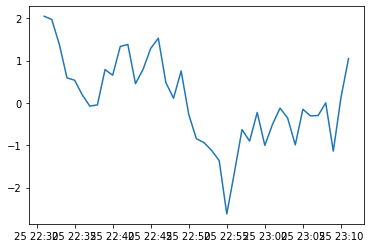

time
2020-04-25 22:12:00         NaN
2020-04-25 22:13:00         NaN
2020-04-25 22:14:00         NaN
2020-04-25 22:15:00         NaN
2020-04-25 22:16:00         NaN
2020-04-25 22:17:00         NaN
2020-04-25 22:18:00         NaN
2020-04-25 22:19:00         NaN
2020-04-25 22:20:00         NaN
2020-04-25 22:21:00         NaN
2020-04-25 22:22:00         NaN
2020-04-25 22:23:00         NaN
2020-04-25 22:24:00         NaN
2020-04-25 22:25:00         NaN
2020-04-25 22:26:00         NaN
2020-04-25 22:27:00         NaN
2020-04-25 22:28:00         NaN
2020-04-25 22:29:00         NaN
2020-04-25 22:30:00         NaN
2020-04-25 22:31:00    1.367882
2020-04-25 22:32:00    0.728533
2020-04-25 22:33:00    0.107024
2020-04-25 22:34:00   -0.247093
2020-04-25 22:35:00   -1.149917
2020-04-25 22:36:00   -0.549891
2020-04-25 22:37:00   -1.136530
2020-04-25 22:38:00   -1.323361
2020-04-25 22:39:00   -0.950400
2020-04-25 22:40:00   -0.453468
2020-04-25 22:41:00    0.633891
2020-04-25 22:42:00   -0.028932
202

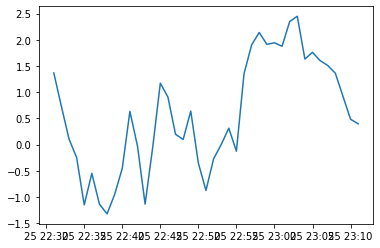

time
2020-04-25 22:12:00         NaN
2020-04-25 22:13:00         NaN
2020-04-25 22:14:00         NaN
2020-04-25 22:15:00         NaN
2020-04-25 22:16:00         NaN
2020-04-25 22:17:00         NaN
2020-04-25 22:18:00         NaN
2020-04-25 22:19:00         NaN
2020-04-25 22:20:00         NaN
2020-04-25 22:21:00         NaN
2020-04-25 22:22:00         NaN
2020-04-25 22:23:00         NaN
2020-04-25 22:24:00         NaN
2020-04-25 22:25:00         NaN
2020-04-25 22:26:00         NaN
2020-04-25 22:27:00         NaN
2020-04-25 22:28:00         NaN
2020-04-25 22:29:00         NaN
2020-04-25 22:30:00         NaN
2020-04-25 22:31:00    2.040783
2020-04-25 22:32:00    1.776532
2020-04-25 22:33:00    1.096549
2020-04-25 22:34:00    0.355994
2020-04-25 22:35:00   -0.095127
2020-04-25 22:36:00   -0.051364
2020-04-25 22:37:00   -0.519257
2020-04-25 22:38:00   -0.501169
2020-04-25 22:39:00    0.285905
2020-04-25 22:40:00    0.263678
2020-04-25 22:41:00    1.229544
2020-04-25 22:42:00    1.034578
202

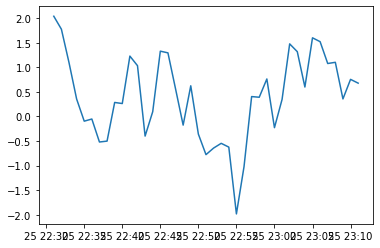

time
2020-04-25 22:12:00             NaN
2020-04-25 22:13:00             NaN
2020-04-25 22:14:00             NaN
2020-04-25 22:15:00             NaN
2020-04-25 22:16:00             NaN
2020-04-25 22:17:00             NaN
2020-04-25 22:18:00             NaN
2020-04-25 22:19:00             NaN
2020-04-25 22:20:00             NaN
2020-04-25 22:21:00             NaN
2020-04-25 22:22:00             NaN
2020-04-25 22:23:00             NaN
2020-04-25 22:24:00             NaN
2020-04-25 22:25:00             NaN
2020-04-25 22:26:00             NaN
2020-04-25 22:27:00             NaN
2020-04-25 22:28:00             NaN
2020-04-25 22:29:00             NaN
2020-04-25 22:30:00             NaN
2020-04-25 22:31:00    5.764438e-01
2020-04-25 22:32:00    1.281599e+00
2020-04-25 22:33:00    1.492189e+00
2020-04-25 22:34:00    1.564580e+00
2020-04-25 22:35:00    1.478182e+00
2020-04-25 22:36:00    2.909178e+00
2020-04-25 22:37:00    1.773581e+00
2020-04-25 22:38:00    1.611575e+00
2020-04-25 22:39:00    

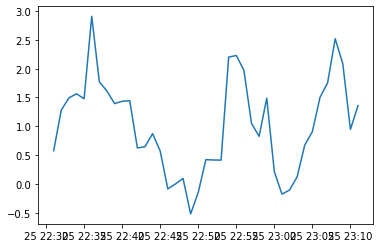

time
2020-04-25 22:12:00         NaN
2020-04-25 22:13:00         NaN
2020-04-25 22:14:00         NaN
2020-04-25 22:15:00         NaN
2020-04-25 22:16:00         NaN
2020-04-25 22:17:00         NaN
2020-04-25 22:18:00         NaN
2020-04-25 22:19:00         NaN
2020-04-25 22:20:00         NaN
2020-04-25 22:21:00         NaN
2020-04-25 22:22:00         NaN
2020-04-25 22:23:00         NaN
2020-04-25 22:24:00         NaN
2020-04-25 22:25:00         NaN
2020-04-25 22:26:00         NaN
2020-04-25 22:27:00         NaN
2020-04-25 22:28:00         NaN
2020-04-25 22:29:00         NaN
2020-04-25 22:30:00         NaN
2020-04-25 22:31:00   -1.293363
2020-04-25 22:32:00   -1.178317
2020-04-25 22:33:00   -1.081784
2020-04-25 22:34:00   -0.982425
2020-04-25 22:35:00   -0.896229
2020-04-25 22:36:00    1.227765
2020-04-25 22:37:00    1.798186
2020-04-25 22:38:00    1.580366
2020-04-25 22:39:00    1.403023
2020-04-25 22:40:00    1.312226
2020-04-25 22:41:00    1.186942
2020-04-25 22:42:00    1.164957
202

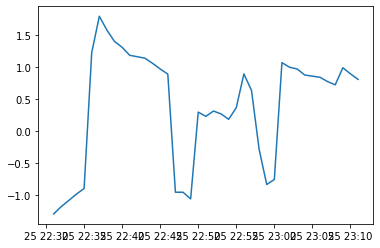

time
2020-04-25 22:12:00         NaN
2020-04-25 22:13:00         NaN
2020-04-25 22:14:00         NaN
2020-04-25 22:15:00         NaN
2020-04-25 22:16:00         NaN
2020-04-25 22:17:00         NaN
2020-04-25 22:18:00         NaN
2020-04-25 22:19:00         NaN
2020-04-25 22:20:00         NaN
2020-04-25 22:21:00         NaN
2020-04-25 22:22:00         NaN
2020-04-25 22:23:00         NaN
2020-04-25 22:24:00         NaN
2020-04-25 22:25:00         NaN
2020-04-25 22:26:00         NaN
2020-04-25 22:27:00         NaN
2020-04-25 22:28:00         NaN
2020-04-25 22:29:00         NaN
2020-04-25 22:30:00         NaN
2020-04-25 22:31:00    1.431106
2020-04-25 22:32:00    1.200831
2020-04-25 22:33:00    1.068667
2020-04-25 22:34:00    0.796135
2020-04-25 22:35:00    0.611542
2020-04-25 22:36:00    0.882475
2020-04-25 22:37:00    0.545281
2020-04-25 22:38:00    0.733317
2020-04-25 22:39:00    0.777573
2020-04-25 22:40:00    0.955541
2020-04-25 22:41:00    1.583574
2020-04-25 22:42:00    1.032341
202

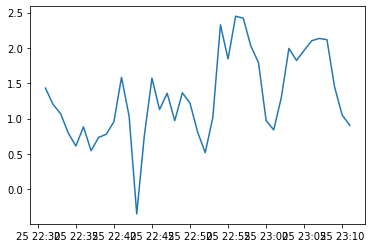

time
2020-04-25 22:12:00         NaN
2020-04-25 22:13:00         NaN
2020-04-25 22:14:00         NaN
2020-04-25 22:15:00         NaN
2020-04-25 22:16:00         NaN
2020-04-25 22:17:00         NaN
2020-04-25 22:18:00         NaN
2020-04-25 22:19:00         NaN
2020-04-25 22:20:00         NaN
2020-04-25 22:21:00         NaN
2020-04-25 22:22:00         NaN
2020-04-25 22:23:00         NaN
2020-04-25 22:24:00         NaN
2020-04-25 22:25:00         NaN
2020-04-25 22:26:00         NaN
2020-04-25 22:27:00         NaN
2020-04-25 22:28:00         NaN
2020-04-25 22:29:00         NaN
2020-04-25 22:30:00         NaN
2020-04-25 22:31:00   -2.505852
2020-04-25 22:32:00   -2.430944
2020-04-25 22:33:00   -1.352612
2020-04-25 22:34:00   -1.678615
2020-04-25 22:35:00   -1.267847
2020-04-25 22:36:00   -1.360172
2020-04-25 22:37:00   -1.489903
2020-04-25 22:38:00   -1.636640
2020-04-25 22:39:00   -1.569592
2020-04-25 22:40:00   -0.668216
2020-04-25 22:41:00   -1.162686
2020-04-25 22:42:00   -0.807505
202

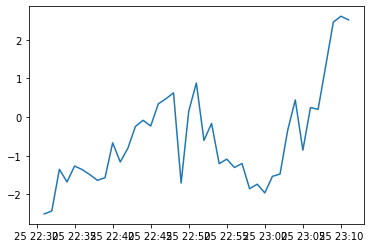

time
2020-04-25 22:12:00         NaN
2020-04-25 22:13:00         NaN
2020-04-25 22:14:00         NaN
2020-04-25 22:15:00         NaN
2020-04-25 22:16:00         NaN
2020-04-25 22:17:00         NaN
2020-04-25 22:18:00         NaN
2020-04-25 22:19:00         NaN
2020-04-25 22:20:00         NaN
2020-04-25 22:21:00         NaN
2020-04-25 22:22:00         NaN
2020-04-25 22:23:00         NaN
2020-04-25 22:24:00         NaN
2020-04-25 22:25:00         NaN
2020-04-25 22:26:00         NaN
2020-04-25 22:27:00         NaN
2020-04-25 22:28:00         NaN
2020-04-25 22:29:00         NaN
2020-04-25 22:30:00         NaN
2020-04-25 22:31:00   -3.141268
2020-04-25 22:32:00   -1.503503
2020-04-25 22:33:00   -1.510079
2020-04-25 22:34:00   -1.094168
2020-04-25 22:35:00   -0.770105
2020-04-25 22:36:00   -1.817481
2020-04-25 22:37:00   -1.219309
2020-04-25 22:38:00   -1.483887
2020-04-25 22:39:00   -2.169935
2020-04-25 22:40:00   -1.333871
2020-04-25 22:41:00   -1.384321
2020-04-25 22:42:00   -1.164660
202

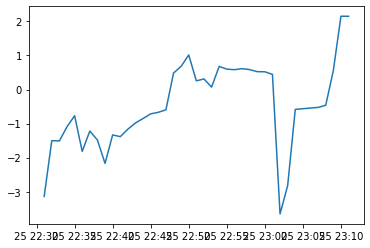

time
2020-04-25 22:12:00         NaN
2020-04-25 22:13:00         NaN
2020-04-25 22:14:00         NaN
2020-04-25 22:15:00         NaN
2020-04-25 22:16:00         NaN
2020-04-25 22:17:00         NaN
2020-04-25 22:18:00         NaN
2020-04-25 22:19:00         NaN
2020-04-25 22:20:00         NaN
2020-04-25 22:21:00         NaN
2020-04-25 22:22:00         NaN
2020-04-25 22:23:00         NaN
2020-04-25 22:24:00         NaN
2020-04-25 22:25:00         NaN
2020-04-25 22:26:00         NaN
2020-04-25 22:27:00         NaN
2020-04-25 22:28:00         NaN
2020-04-25 22:29:00         NaN
2020-04-25 22:30:00         NaN
2020-04-25 22:31:00   -2.054812
2020-04-25 22:32:00   -2.005094
2020-04-25 22:33:00   -2.085106
2020-04-25 22:34:00   -1.790825
2020-04-25 22:35:00   -1.572375
2020-04-25 22:36:00   -1.400009
2020-04-25 22:37:00   -1.258091
2020-04-25 22:38:00   -1.567599
2020-04-25 22:39:00   -1.819310
2020-04-25 22:40:00    0.574080
2020-04-25 22:41:00    0.642414
2020-04-25 22:42:00    0.045118
202

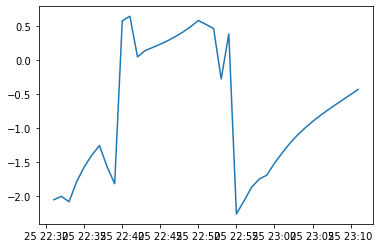

time
2020-04-25 22:12:00         NaN
2020-04-25 22:13:00         NaN
2020-04-25 22:14:00         NaN
2020-04-25 22:15:00         NaN
2020-04-25 22:16:00         NaN
2020-04-25 22:17:00         NaN
2020-04-25 22:18:00         NaN
2020-04-25 22:19:00         NaN
2020-04-25 22:20:00         NaN
2020-04-25 22:21:00         NaN
2020-04-25 22:22:00         NaN
2020-04-25 22:23:00         NaN
2020-04-25 22:24:00         NaN
2020-04-25 22:25:00         NaN
2020-04-25 22:26:00         NaN
2020-04-25 22:27:00         NaN
2020-04-25 22:28:00         NaN
2020-04-25 22:29:00         NaN
2020-04-25 22:30:00         NaN
2020-04-25 22:31:00   -1.300272
2020-04-25 22:32:00   -2.545823
2020-04-25 22:33:00   -2.228635
2020-04-25 22:34:00   -1.894368
2020-04-25 22:35:00   -1.653639
2020-04-25 22:36:00   -1.591422
2020-04-25 22:37:00   -1.117124
2020-04-25 22:38:00   -0.807260
2020-04-25 22:39:00   -0.813720
2020-04-25 22:40:00   -0.335694
2020-04-25 22:41:00   -0.572145
2020-04-25 22:42:00   -0.530734
202

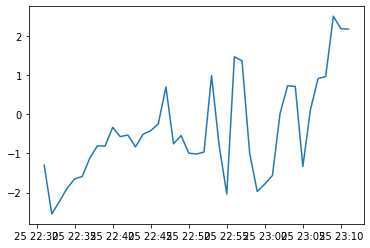

In [8]:
for symbol in symbols.keys():
    print(symbols[symbol].CCI)
    plt.plot(symbols[symbol].CCI)
    plt.show()

time
2020-04-25 22:12:00     True
2020-04-25 22:15:00     True
2020-04-25 22:25:00     True
2020-04-25 22:30:00     True
2020-04-25 22:55:00    False
Name: uptrend, dtype: bool


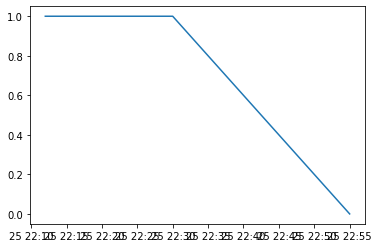

time
2020-04-25 22:12:00    True
2020-04-25 22:24:00    True
2020-04-25 23:00:00    True
2020-04-25 23:03:00    True
Name: uptrend, dtype: bool


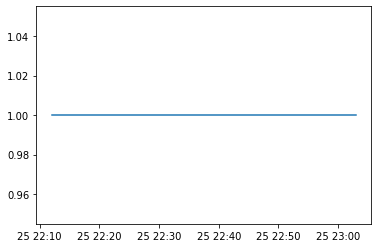

time
2020-04-25 22:12:00     True
2020-04-25 22:15:00     True
2020-04-25 22:25:00     True
2020-04-25 22:31:00     True
2020-04-25 22:55:00    False
2020-04-25 23:05:00     True
Name: uptrend, dtype: bool


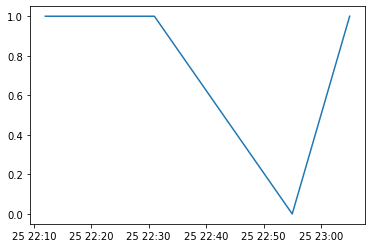

time
2020-04-25 22:12:00    True
2020-04-25 22:36:00    True
2020-04-25 22:36:00    True
Name: uptrend, dtype: bool


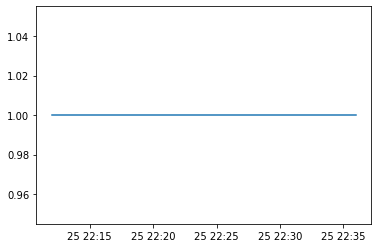

time
2020-04-25 22:12:00     True
2020-04-25 22:14:00    False
2020-04-25 22:16:00     True
2020-04-25 22:18:00    False
2020-04-25 22:18:00    False
2020-04-25 22:19:00     True
2020-04-25 22:20:00    False
2020-04-25 22:22:00     True
2020-04-25 22:24:00    False
2020-04-25 22:27:00    False
2020-04-25 22:29:00    False
2020-04-25 22:36:00     True
2020-04-25 22:36:00     True
2020-04-25 22:36:00     True
2020-04-25 22:36:00     True
2020-04-25 22:47:00    False
2020-04-25 22:47:00    False
2020-04-25 22:47:00    False
2020-04-25 22:50:00     True
2020-04-25 22:52:00     True
2020-04-25 22:56:00     True
2020-04-25 22:58:00    False
2020-04-25 23:01:00     True
Name: uptrend, dtype: bool


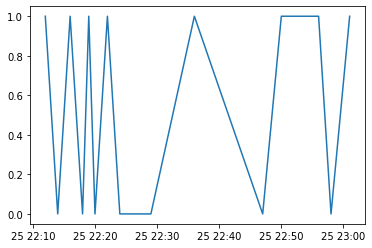

time
2020-04-25 22:12:00     True
2020-04-25 22:15:00     True
2020-04-25 22:16:00    False
2020-04-25 22:53:00     True
2020-04-25 22:56:00     True
2020-04-25 23:05:00     True
2020-04-25 23:07:00     True
Name: uptrend, dtype: bool


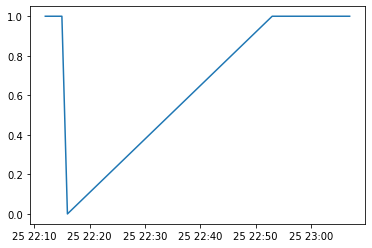

time
2020-04-25 22:12:00     True
2020-04-25 22:32:00    False
2020-04-25 22:39:00    False
2020-04-25 23:09:00     True
2020-04-25 23:11:00     True
Name: uptrend, dtype: bool


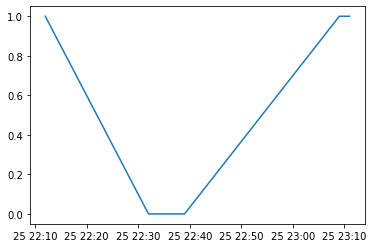

time
2020-04-25 22:12:00     True
2020-04-25 22:16:00    False
2020-04-25 22:31:00    False
2020-04-25 22:31:00    False
2020-04-25 22:38:00    False
2020-04-25 22:39:00    False
2020-04-25 22:39:00    False
2020-04-25 22:39:00    False
2020-04-25 22:40:00     True
2020-04-25 22:47:00     True
2020-04-25 22:48:00     True
2020-04-25 23:02:00    False
2020-04-25 23:02:00    False
2020-04-25 23:02:00    False
2020-04-25 23:04:00     True
2020-04-25 23:09:00     True
2020-04-25 23:09:00     True
2020-04-25 23:10:00     True
2020-04-25 23:10:00     True
2020-04-25 23:10:00     True
Name: uptrend, dtype: bool


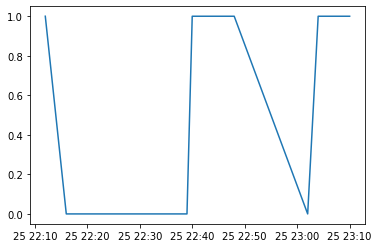

time
2020-04-25 22:12:00     True
2020-04-25 22:14:00    False
2020-04-25 22:14:00    False
2020-04-25 22:14:00    False
2020-04-25 22:14:00    False
2020-04-25 22:14:00    False
2020-04-25 22:14:00    False
2020-04-25 22:14:00    False
2020-04-25 22:14:00    False
2020-04-25 22:14:00    False
2020-04-25 22:14:00    False
2020-04-25 22:14:00    False
2020-04-25 22:14:00    False
2020-04-25 22:24:00    False
2020-04-25 22:24:00    False
2020-04-25 22:24:00    False
2020-04-25 22:24:00    False
2020-04-25 22:24:00    False
2020-04-25 22:31:00    False
2020-04-25 22:31:00    False
2020-04-25 22:31:00    False
2020-04-25 22:31:00    False
2020-04-25 22:31:00    False
2020-04-25 22:31:00    False
2020-04-25 22:31:00    False
2020-04-25 22:31:00    False
2020-04-25 22:31:00    False
2020-04-25 22:38:00    False
2020-04-25 22:38:00    False
2020-04-25 22:38:00    False
                       ...  
2020-04-25 22:39:00    False
2020-04-25 22:40:00     True
2020-04-25 22:40:00     True
2020-04-2

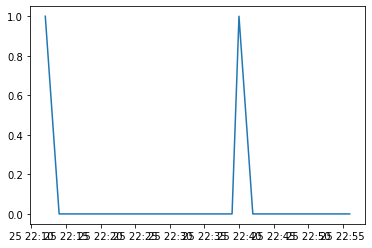

time
2020-04-25 22:12:00     True
2020-04-25 22:13:00     True
2020-04-25 22:32:00    False
2020-04-25 22:59:00    False
2020-04-25 23:09:00     True
Name: uptrend, dtype: bool


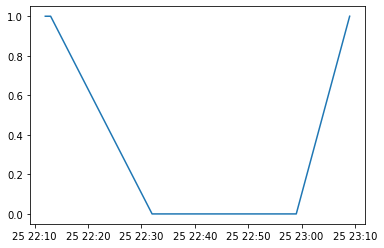

In [9]:
for symbol in symbols.keys():
    print(symbols[symbol].renko)
    plt.plot(symbols[symbol].renko)
    plt.show()

time
2020-04-25 22:38:00    0.376482
2020-04-25 22:39:00    0.365222
2020-04-25 22:40:00    0.376531
2020-04-25 22:41:00    0.387696
2020-04-25 22:42:00    0.356940
2020-04-25 22:43:00    0.344706
2020-04-25 22:44:00    0.340837
2020-04-25 22:45:00    0.344059
2020-04-25 22:46:00    0.310588
2020-04-25 22:47:00    0.281952
2020-04-25 22:48:00    0.290531
2020-04-25 22:49:00    0.293608
2020-04-25 22:50:00    0.282886
2020-04-25 22:51:00    0.269049
2020-04-25 22:52:00    0.247440
2020-04-25 22:53:00    0.217423
2020-04-25 22:54:00    0.254539
2020-04-25 22:55:00    0.291945
2020-04-25 22:56:00    0.283190
2020-04-25 22:57:00    0.275625
2020-04-25 22:58:00    0.245301
2020-04-25 22:59:00    0.239461
2020-04-25 23:00:00    0.230778
2020-04-25 23:01:00    0.223266
2020-04-25 23:02:00    0.216765
2020-04-25 23:03:00    0.221528
2020-04-25 23:04:00    0.205833
2020-04-25 23:05:00    0.192242
2020-04-25 23:06:00    0.175557
2020-04-25 23:07:00    0.177712
2020-04-25 23:08:00    0.181409
202

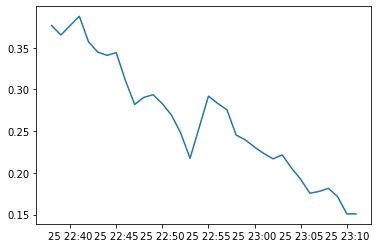

time
2020-04-25 22:38:00    0.230105
2020-04-25 22:39:00    0.221090
2020-04-25 22:40:00    0.241765
2020-04-25 22:41:00    0.231754
2020-04-25 22:42:00    0.204116
2020-04-25 22:43:00    0.193998
2020-04-25 22:44:00    0.200838
2020-04-25 22:45:00    0.223700
2020-04-25 22:46:00    0.234112
2020-04-25 22:47:00    0.243020
2020-04-25 22:48:00    0.279026
2020-04-25 22:49:00    0.274692
2020-04-25 22:50:00    0.241407
2020-04-25 22:51:00    0.230329
2020-04-25 22:52:00    0.220787
2020-04-25 22:53:00    0.212561
2020-04-25 22:54:00    0.196189
2020-04-25 22:55:00    0.193871
2020-04-25 22:56:00    0.191870
2020-04-25 22:57:00    0.198943
2020-04-25 22:58:00    0.206805
2020-04-25 22:59:00    0.222300
2020-04-25 23:00:00    0.244212
2020-04-25 23:01:00    0.293919
2020-04-25 23:02:00    0.339130
2020-04-25 23:03:00    0.346134
2020-04-25 23:04:00    0.352197
2020-04-25 23:05:00    0.363860
2020-04-25 23:06:00    0.371704
2020-04-25 23:07:00    0.383890
2020-04-25 23:08:00    0.341069
202

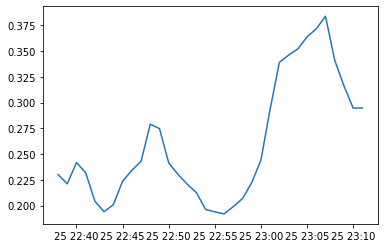

time
2020-04-25 22:38:00    0.286445
2020-04-25 22:39:00    0.296002
2020-04-25 22:40:00    0.326364
2020-04-25 22:41:00    0.354354
2020-04-25 22:42:00    0.317878
2020-04-25 22:43:00    0.289106
2020-04-25 22:44:00    0.289322
2020-04-25 22:45:00    0.291217
2020-04-25 22:46:00    0.276445
2020-04-25 22:47:00    0.242912
2020-04-25 22:48:00    0.253503
2020-04-25 22:49:00    0.245789
2020-04-25 22:50:00    0.218714
2020-04-25 22:51:00    0.202070
2020-04-25 22:52:00    0.176841
2020-04-25 22:53:00    0.155092
2020-04-25 22:54:00    0.173785
2020-04-25 22:55:00    0.168931
2020-04-25 22:56:00    0.159019
2020-04-25 22:57:00    0.150455
2020-04-25 22:58:00    0.150252
2020-04-25 22:59:00    0.163116
2020-04-25 23:00:00    0.158571
2020-04-25 23:01:00    0.148745
2020-04-25 23:02:00    0.140243
2020-04-25 23:03:00    0.131702
2020-04-25 23:04:00    0.126953
2020-04-25 23:05:00    0.125036
2020-04-25 23:06:00    0.114577
2020-04-25 23:07:00    0.118531
2020-04-25 23:08:00    0.125301
202

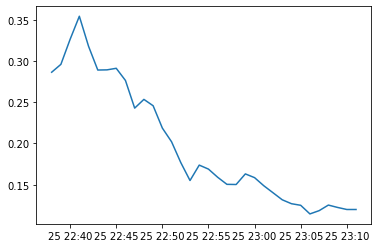

time
2020-04-25 22:38:00    0.567609
2020-04-25 22:39:00    0.608927
2020-04-25 22:40:00    0.643397
2020-04-25 22:41:00    0.553994
2020-04-25 22:42:00    0.478626
2020-04-25 22:43:00    0.435929
2020-04-25 22:44:00    0.392635
2020-04-25 22:45:00    0.345169
2020-04-25 22:46:00    0.329652
2020-04-25 22:47:00    0.324128
2020-04-25 22:48:00    0.319393
2020-04-25 22:49:00    0.331195
2020-04-25 22:50:00    0.351374
2020-04-25 22:51:00    0.382361
2020-04-25 22:52:00    0.391602
2020-04-25 22:53:00    0.424925
2020-04-25 22:54:00    0.458414
2020-04-25 22:55:00    0.479222
2020-04-25 22:56:00    0.459924
2020-04-25 22:57:00    0.430063
2020-04-25 22:58:00    0.408407
2020-04-25 22:59:00    0.363932
2020-04-25 23:00:00    0.338522
2020-04-25 23:01:00    0.316537
2020-04-25 23:02:00    0.278136
2020-04-25 23:03:00    0.244897
2020-04-25 23:04:00    0.242178
2020-04-25 23:05:00    0.239823
2020-04-25 23:06:00    0.263432
2020-04-25 23:07:00    0.303362
2020-04-25 23:08:00    0.302308
202

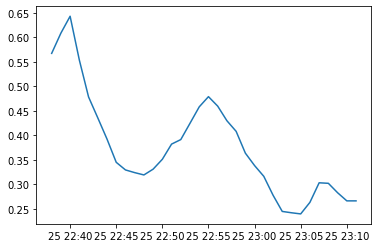

time
2020-04-25 22:38:00    0.419228
2020-04-25 22:39:00    0.424484
2020-04-25 22:40:00    0.428869
2020-04-25 22:41:00    0.432548
2020-04-25 22:42:00    0.435650
2020-04-25 22:43:00    0.438275
2020-04-25 22:44:00    0.440504
2020-04-25 22:45:00    0.442403
2020-04-25 22:46:00    0.462146
2020-04-25 22:47:00    0.479038
2020-04-25 22:48:00    0.496284
2020-04-25 22:49:00    0.443171
2020-04-25 22:50:00    0.397519
2020-04-25 22:51:00    0.366298
2020-04-25 22:52:00    0.339407
2020-04-25 22:53:00    0.316224
2020-04-25 22:54:00    0.308110
2020-04-25 22:55:00    0.322201
2020-04-25 22:56:00    0.291821
2020-04-25 22:57:00    0.276946
2020-04-25 22:58:00    0.264088
2020-04-25 22:59:00    0.252969
2020-04-25 23:00:00    0.261958
2020-04-25 23:01:00    0.267925
2020-04-25 23:02:00    0.273089
2020-04-25 23:03:00    0.272918
2020-04-25 23:04:00    0.272770
2020-04-25 23:05:00    0.272642
2020-04-25 23:06:00    0.272531
2020-04-25 23:07:00    0.272435
2020-04-25 23:08:00    0.282587
202

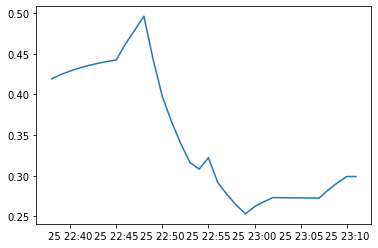

time
2020-04-25 22:38:00    0.172886
2020-04-25 22:39:00    0.157058
2020-04-25 22:40:00    0.184852
2020-04-25 22:41:00    0.159125
2020-04-25 22:42:00    0.156451
2020-04-25 22:43:00    0.167694
2020-04-25 22:44:00    0.177686
2020-04-25 22:45:00    0.163907
2020-04-25 22:46:00    0.152142
2020-04-25 22:47:00    0.142077
2020-04-25 22:48:00    0.153195
2020-04-25 22:49:00    0.161707
2020-04-25 22:50:00    0.141732
2020-04-25 22:51:00    0.124544
2020-04-25 22:52:00    0.125145
2020-04-25 22:53:00    0.152650
2020-04-25 22:54:00    0.176377
2020-04-25 22:55:00    0.222312
2020-04-25 22:56:00    0.265470
2020-04-25 22:57:00    0.302762
2020-04-25 22:58:00    0.342969
2020-04-25 22:59:00    0.297196
2020-04-25 23:00:00    0.257603
2020-04-25 23:01:00    0.244663
2020-04-25 23:02:00    0.256328
2020-04-25 23:03:00    0.266426
2020-04-25 23:04:00    0.300621
2020-04-25 23:05:00    0.337469
2020-04-25 23:06:00    0.380615
2020-04-25 23:07:00    0.425367
2020-04-25 23:08:00    0.399574
202

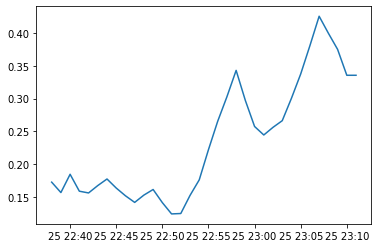

time
2020-04-25 22:38:00    0.722536
2020-04-25 22:39:00    0.724386
2020-04-25 22:40:00    0.735484
2020-04-25 22:41:00    0.673276
2020-04-25 22:42:00    0.620835
2020-04-25 22:43:00    0.576448
2020-04-25 22:44:00    0.562036
2020-04-25 22:45:00    0.532376
2020-04-25 22:46:00    0.507052
2020-04-25 22:47:00    0.485386
2020-04-25 22:48:00    0.509291
2020-04-25 22:49:00    0.513298
2020-04-25 22:50:00    0.516742
2020-04-25 22:51:00    0.537225
2020-04-25 22:52:00    0.561131
2020-04-25 22:53:00    0.587093
2020-04-25 22:54:00    0.609491
2020-04-25 22:55:00    0.631628
2020-04-25 22:56:00    0.650747
2020-04-25 22:57:00    0.667268
2020-04-25 22:58:00    0.687794
2020-04-25 22:59:00    0.705542
2020-04-25 23:00:00    0.720895
2020-04-25 23:01:00    0.737462
2020-04-25 23:02:00    0.672674
2020-04-25 23:03:00    0.593976
2020-04-25 23:04:00    0.552768
2020-04-25 23:05:00    0.504522
2020-04-25 23:06:00    0.462743
2020-04-25 23:07:00    0.412437
2020-04-25 23:08:00    0.401015
202

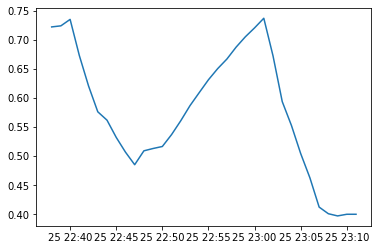

time
2020-04-25 22:38:00    0.689975
2020-04-25 22:39:00    0.713765
2020-04-25 22:40:00    0.735269
2020-04-25 22:41:00    0.753312
2020-04-25 22:42:00    0.763391
2020-04-25 22:43:00    0.771923
2020-04-25 22:44:00    0.747858
2020-04-25 22:45:00    0.731729
2020-04-25 22:46:00    0.734603
2020-04-25 22:47:00    0.736691
2020-04-25 22:48:00    0.738482
2020-04-25 22:49:00    0.740018
2020-04-25 22:50:00    0.746904
2020-04-25 22:51:00    0.752830
2020-04-25 22:52:00    0.760128
2020-04-25 22:53:00    0.728000
2020-04-25 22:54:00    0.703592
2020-04-25 22:55:00    0.682522
2020-04-25 22:56:00    0.664324
2020-04-25 22:57:00    0.648600
2020-04-25 22:58:00    0.635007
2020-04-25 22:59:00    0.617944
2020-04-25 23:00:00    0.603185
2020-04-25 23:01:00    0.641654
2020-04-25 23:02:00    0.674946
2020-04-25 23:03:00    0.598793
2020-04-25 23:04:00    0.532865
2020-04-25 23:05:00    0.475781
2020-04-25 23:06:00    0.426349
2020-04-25 23:07:00    0.383538
2020-04-25 23:08:00    0.371966
202

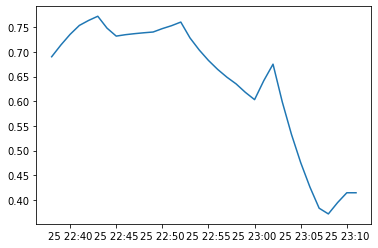

time
2020-04-25 22:38:00    0.977286
2020-04-25 22:39:00    0.872507
2020-04-25 22:40:00    0.785090
2020-04-25 22:41:00    0.677001
2020-04-25 22:42:00    0.585881
2020-04-25 22:43:00    0.508757
2020-04-25 22:44:00    0.443259
2020-04-25 22:45:00    0.387475
2020-04-25 22:46:00    0.339847
2020-04-25 22:47:00    0.299098
2020-04-25 22:48:00    0.264172
2020-04-25 22:49:00    0.234191
2020-04-25 22:50:00    0.208422
2020-04-25 22:51:00    0.186246
2020-04-25 22:52:00    0.245825
2020-04-25 22:53:00    0.297186
2020-04-25 22:54:00    0.369099
2020-04-25 22:55:00    0.432401
2020-04-25 22:56:00    0.487074
2020-04-25 22:57:00    0.534619
2020-04-25 22:58:00    0.571803
2020-04-25 22:59:00    0.603957
2020-04-25 23:00:00    0.631770
2020-04-25 23:01:00    0.655835
2020-04-25 23:02:00    0.676661
2020-04-25 23:03:00    0.694687
2020-04-25 23:04:00    0.710293
2020-04-25 23:05:00    0.723805
2020-04-25 23:06:00    0.735506
2020-04-25 23:07:00    0.745640
2020-04-25 23:08:00    0.754417
202

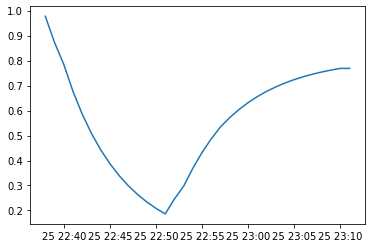

time
2020-04-25 22:38:00    0.399361
2020-04-25 22:39:00    0.341925
2020-04-25 22:40:00    0.316383
2020-04-25 22:41:00    0.296282
2020-04-25 22:42:00    0.308669
2020-04-25 22:43:00    0.292856
2020-04-25 22:44:00    0.290655
2020-04-25 22:45:00    0.288779
2020-04-25 22:46:00    0.275226
2020-04-25 22:47:00    0.247561
2020-04-25 22:48:00    0.223848
2020-04-25 22:49:00    0.214962
2020-04-25 22:50:00    0.207325
2020-04-25 22:51:00    0.200752
2020-04-25 22:52:00    0.216408
2020-04-25 22:53:00    0.217363
2020-04-25 22:54:00    0.218186
2020-04-25 22:55:00    0.262131
2020-04-25 22:56:00    0.300086
2020-04-25 22:57:00    0.275197
2020-04-25 22:58:00    0.246759
2020-04-25 22:59:00    0.222167
2020-04-25 23:00:00    0.200895
2020-04-25 23:01:00    0.212467
2020-04-25 23:02:00    0.222482
2020-04-25 23:03:00    0.231150
2020-04-25 23:04:00    0.218939
2020-04-25 23:05:00    0.212533
2020-04-25 23:06:00    0.206985
2020-04-25 23:07:00    0.205435
2020-04-25 23:08:00    0.245510
202

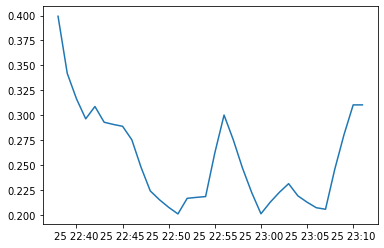

In [10]:
for symbol in symbols.keys():
    print(symbols[symbol].ADX)
    plt.plot(symbols[symbol].ADX)
    plt.show()

                             K          D           J
time                                                 
2020-04-25 22:12:00  52.083333  50.694444   54.861111
2020-04-25 22:13:00  46.216475  49.201788   40.245849
2020-04-25 22:14:00  41.155811  46.519796   30.427842
2020-04-25 22:15:00  60.770541  51.270044   79.771534
2020-04-25 22:16:00  45.919099  49.486396   38.784506
2020-04-25 22:17:00  39.621742  46.198178   26.468870
2020-04-25 22:18:00  50.738819  47.711725   56.793007
2020-04-25 22:19:00  50.086042  48.503164   53.251798
2020-04-25 22:20:00  40.707768  45.904698   30.313906
2020-04-25 22:21:00  42.523127  44.777508   38.014366
2020-04-25 22:22:00  43.733367  44.429461   42.341179
2020-04-25 22:23:00  50.523099  46.460674   58.647950
2020-04-25 22:24:00  61.887194  51.602847   82.455889
2020-04-25 22:25:00  74.591463  59.265719  105.242950
2020-04-25 22:26:00  79.808943  66.113460  107.199908
2020-04-25 22:27:00  82.751416  71.659446  104.935358
2020-04-25 22:28:00  85.4706

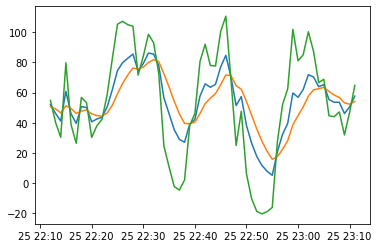

                             K          D           J
time                                                 
2020-04-25 22:12:00  43.247863  47.749288   34.245014
2020-04-25 22:13:00  52.402341  49.300306   58.606412
2020-04-25 22:14:00  53.814562  50.805058   59.833571
2020-04-25 22:15:00  54.410261  52.006792   59.217200
2020-04-25 22:16:00  39.206269  47.739951   22.138904
2020-04-25 22:17:00  32.360688  42.613530   11.855005
2020-04-25 22:18:00  38.562347  41.263136   33.160770
2020-04-25 22:19:00  40.515099  41.013790   39.517715
2020-04-25 22:20:00  39.885602  40.637727   38.381352
2020-04-25 22:21:00  50.195552  43.823669   62.939317
2020-04-25 22:22:00  57.462270  48.369869   75.647073
2020-04-25 22:23:00  61.305319  52.681686   78.552585
2020-04-25 22:24:00  73.540002  59.634458  101.351090
2020-04-25 22:25:00  70.758072  63.342329   85.589557
2020-04-25 22:26:00  63.262013  63.315557   63.154925
2020-04-25 22:27:00  70.438749  65.689954   79.936337
2020-04-25 22:28:00  70.9497

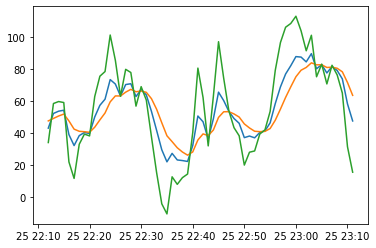

                             K          D           J
time                                                 
2020-04-25 22:12:00  61.904762  53.968254   77.777778
2020-04-25 22:13:00  58.441558  55.459355   64.405964
2020-04-25 22:14:00  54.112554  55.010422   52.316819
2020-04-25 22:15:00  67.698968  59.239937   84.617029
2020-04-25 22:16:00  45.873386  54.784420   28.051318
2020-04-25 22:17:00  37.989665  49.186168   15.596658
2020-04-25 22:18:00  49.770888  49.381075   50.550513
2020-04-25 22:19:00  51.699110  50.153753   54.789824
2020-04-25 22:20:00  44.095703  48.134403   36.018303
2020-04-25 22:21:00  47.915654  48.061487   47.623988
2020-04-25 22:22:00  56.388214  50.837062   67.490516
2020-04-25 22:23:00  61.295846  54.323324   75.240891
2020-04-25 22:24:00  74.197231  60.947959  100.695774
2020-04-25 22:25:00  81.074016  67.656645  107.908758
2020-04-25 22:26:00  81.209838  72.174376   99.280762
2020-04-25 22:27:00  87.473225  77.273992  107.871691
2020-04-25 22:28:00  89.7257

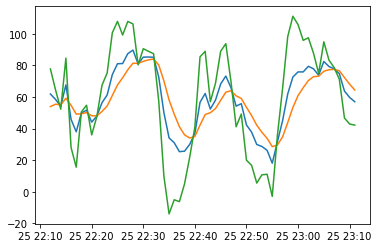

                             K          D           J
time                                                 
2020-04-25 22:12:00  66.666667  55.555556   88.888889
2020-04-25 22:13:00  71.111111  60.740741   91.851852
2020-04-25 22:14:00  75.407407  65.629630   94.962963
2020-04-25 22:15:00  75.604938  68.954733   88.905350
2020-04-25 22:16:00  55.165197  64.358221   36.779150
2020-04-25 22:17:00  46.300607  58.339016   22.223790
2020-04-25 22:18:00  47.961089  54.879707   34.123852
2020-04-25 22:19:00  42.230469  50.663295   25.364819
2020-04-25 22:20:00  39.006359  46.777650   23.463779
2020-04-25 22:21:00  46.934472  46.829924   47.143569
2020-04-25 22:22:00  50.093067  47.917638   54.443925
2020-04-25 22:23:00  54.762899  50.199392   63.889914
2020-04-25 22:24:00  55.806845  52.068543   63.283450
2020-04-25 22:25:00  66.834193  56.990426   86.521727
2020-04-25 22:26:00  72.951190  62.310681   94.232209
2020-04-25 22:27:00  69.621781  64.747714   79.369915
2020-04-25 22:28:00  66.1676

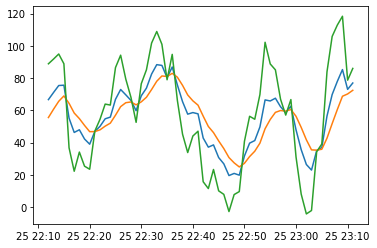

                             K          D           J
time                                                 
2020-04-25 22:12:00  33.333333  44.444444   11.111111
2020-04-25 22:13:00  22.222222  37.037037   -7.407407
2020-04-25 22:14:00  14.814815  29.629630  -14.814815
2020-04-25 22:15:00   9.876543  23.045267  -16.460905
2020-04-25 22:16:00  39.917695  28.669410   62.414266
2020-04-25 22:17:00  59.678464  39.005761  101.023868
2020-04-25 22:18:00  39.785642  39.265722   40.825484
2020-04-25 22:19:00  53.550789  44.027411   72.597545
2020-04-25 22:20:00  35.700526  41.251782   24.598013
2020-04-25 22:21:00  23.800351  35.434638    0.531775
2020-04-25 22:22:00  40.737367  37.202214   47.807671
2020-04-25 22:23:00  51.683288  42.029239   70.991385
2020-04-25 22:24:00  39.636872  41.231783   36.447050
2020-04-25 22:25:00  31.632915  38.032160   18.834423
2020-04-25 22:26:00  27.112706  34.392342   12.553434
2020-04-25 22:27:00  18.075138  28.953274   -3.681136
2020-04-25 22:28:00  12.0500

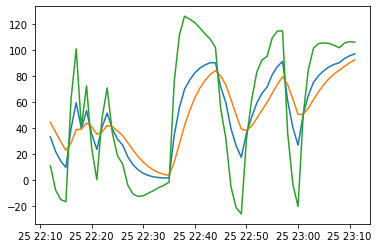

                             K          D           J
time                                                 
2020-04-25 22:12:00  66.666667  55.555556   88.888889
2020-04-25 22:13:00  73.436693  61.515935   97.278208
2020-04-25 22:14:00  77.044215  66.692028   97.748588
2020-04-25 22:15:00  83.152933  72.178996  105.100807
2020-04-25 22:16:00  56.693150  67.017048   36.045356
2020-04-25 22:17:00  39.152023  57.728706    1.998656
2020-04-25 22:18:00  26.585845  47.347752  -14.937971
2020-04-25 22:19:00  18.400225  37.698577  -20.196478
2020-04-25 22:20:00  21.985254  32.460802    1.034158
2020-04-25 22:21:00  37.000161  33.973922   43.052638
2020-04-25 22:22:00  39.653150  35.866998   47.225454
2020-04-25 22:23:00  36.239355  35.991117   36.735831
2020-04-25 22:24:00  40.092484  37.358239   45.560973
2020-04-25 22:25:00  42.594989  39.103822   49.577323
2020-04-25 22:26:00  48.263326  42.156990   60.475998
2020-04-25 22:27:00  64.442217  49.585399   94.155854
2020-04-25 22:28:00  75.0948

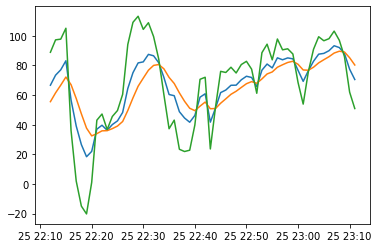

                             K          D           J
time                                                 
2020-04-25 22:12:00  55.555556  51.851852   62.962963
2020-04-25 22:13:00  37.037037  46.913580   17.283951
2020-04-25 22:14:00  58.024691  50.617284   72.839506
2020-04-25 22:15:00  38.683128  46.639232   22.770919
2020-04-25 22:16:00  31.344307  41.540924   10.951075
2020-04-25 22:17:00  37.562872  40.214906   32.258802
2020-04-25 22:18:00  41.708581  40.712798   43.700147
2020-04-25 22:19:00  50.027943  43.817846   62.448136
2020-04-25 22:20:00  38.907517  42.181070   32.360413
2020-04-25 22:21:00  42.605012  42.322384   43.170267
2020-04-25 22:22:00  61.736674  48.793814   87.622395
2020-04-25 22:23:00  52.268894  49.952174   56.902334
2020-04-25 22:24:00  62.623707  54.176018   79.519085
2020-04-25 22:25:00  65.558662  57.970233   80.735520
2020-04-25 22:26:00  71.483552  62.474673   89.501312
2020-04-25 22:27:00  53.211257  59.386868   40.860036
2020-04-25 22:28:00  35.4741

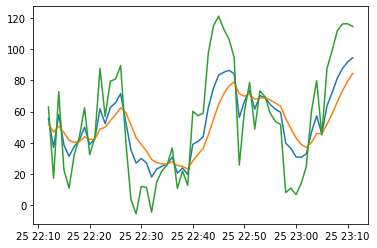

                             K          D           J
time                                                 
2020-04-25 22:12:00  66.666667  55.555556   88.888889
2020-04-25 22:13:00  68.803419  59.971510   86.467236
2020-04-25 22:14:00  70.227920  63.390313   83.903134
2020-04-25 22:15:00  71.177588  65.986072   81.560620
2020-04-25 22:16:00  47.451725  59.807956   22.739263
2020-04-25 22:17:00  31.634483  50.416799   -5.930147
2020-04-25 22:18:00  21.089656  40.641084  -18.013202
2020-04-25 22:19:00  44.213279  41.831816   48.976206
2020-04-25 22:20:00  59.409730  47.691121   82.846949
2020-04-25 22:21:00  70.558868  55.313703  101.049197
2020-04-25 22:22:00  79.308749  63.312052  111.302143
2020-04-25 22:23:00  84.905596  70.509900  113.696989
2020-04-25 22:24:00  88.636828  76.552209  112.806065
2020-04-25 22:25:00  91.124315  81.409578  110.553790
2020-04-25 22:26:00  92.782640  85.200599  107.946724
2020-04-25 22:27:00  61.855094  77.418764   30.727754
2020-04-25 22:28:00  62.3588

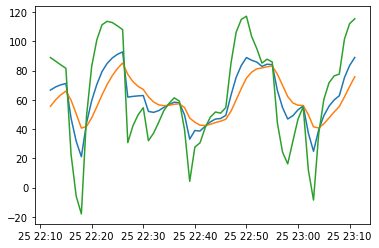

                             K          D           J
time                                                 
2020-04-25 22:12:00  33.333333  44.444444   11.111111
2020-04-25 22:13:00  22.222222  37.037037   -7.407407
2020-04-25 22:14:00  14.814815  29.629630  -14.814815
2020-04-25 22:15:00   9.876543  23.045267  -16.460905
2020-04-25 22:16:00   6.584362  17.558299  -15.363512
2020-04-25 22:17:00   4.389575  13.168724  -13.168724
2020-04-25 22:18:00   2.926383   9.754611  -10.730072
2020-04-25 22:19:00   1.950922   7.153381   -8.453996
2020-04-25 22:20:00   1.300615   5.202459   -6.503074
2020-04-25 22:21:00   0.867076   3.757331   -4.913433
2020-04-25 22:22:00   0.578051   2.697571   -3.660990
2020-04-25 22:23:00   0.385367   1.926837   -2.697571
2020-04-25 22:24:00   0.256912   1.370195   -1.969655
2020-04-25 22:25:00   0.171274   0.970555   -1.427286
2020-04-25 22:26:00   0.114183   0.685097   -1.027646
2020-04-25 22:27:00   1.465011   0.945069    2.504895
2020-04-25 22:28:00   2.3655

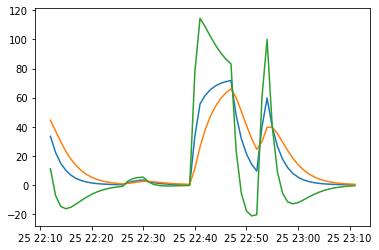

                             K          D           J
time                                                 
2020-04-25 22:12:00  65.555556  55.185185   86.296296
2020-04-25 22:13:00  77.037037  62.469136  106.172840
2020-04-25 22:14:00  84.691358  69.876543  114.320988
2020-04-25 22:15:00  89.794239  76.515775  116.351166
2020-04-25 22:16:00  69.386635  74.139395   59.881116
2020-04-25 22:17:00  55.781566  68.020119   31.304461
2020-04-25 22:18:00  46.711520  60.917253   18.300056
2020-04-25 22:19:00  64.041447  61.958651   68.207038
2020-04-25 22:20:00  75.161830  66.359711   92.766069
2020-04-25 22:21:00  81.828317  71.515913  102.453125
2020-04-25 22:22:00  77.279484  73.437103   84.964246
2020-04-25 22:23:00  80.475885  75.783364   89.860927
2020-04-25 22:24:00  84.290321  78.619016   95.632930
2020-04-25 22:25:00  89.526880  82.254971  104.070700
2020-04-25 22:26:00  93.017920  85.842621  107.368520
2020-04-25 22:27:00  91.850657  87.845299   99.861371
2020-04-25 22:28:00  65.8036

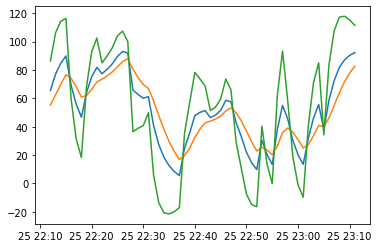

In [11]:
for symbol in symbols.keys():
    print(symbols[symbol].KDJ)
    plt.plot(symbols[symbol].KDJ)
    plt.show()

                             MACD   signal_line     histogram
time                                                         
2020-04-25 22:12:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-25 22:13:00  2.243590e-08  1.246439e-08  9.971510e-09
2020-04-25 22:14:00 -2.422154e-09  6.363346e-09 -8.785500e-09
2020-04-25 22:15:00  9.972606e-07  3.420332e-07  6.552275e-07
2020-04-25 22:16:00  2.859171e-07  3.253399e-07 -3.942281e-08
2020-04-25 22:17:00  2.397121e-08  2.436522e-07 -2.196810e-07
2020-04-25 22:18:00  6.256985e-07  3.403379e-07  2.853606e-07
2020-04-25 22:19:00  6.861961e-07  4.234542e-07  2.627419e-07
2020-04-25 22:20:00  1.718987e-07  3.653436e-07 -1.934449e-07
2020-04-25 22:21:00  3.711718e-07  3.666495e-07  4.522345e-09
2020-04-25 22:22:00  5.099643e-07  3.980059e-07  1.119584e-07
2020-04-25 22:23:00  9.892988e-07  5.249908e-07  4.643080e-07
2020-04-25 22:24:00  1.783568e-06  7.913495e-07  9.922186e-07
2020-04-25 22:25:00  3.050399e-06  1.263944e-06  1.786454e-06
2020-04-

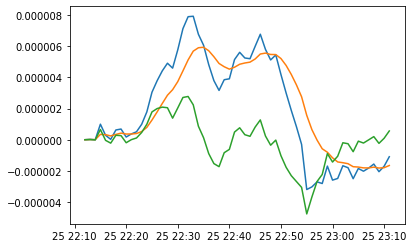

                         MACD  signal_line  histogram
time                                                 
2020-04-25 22:12:00  0.000000     0.000000   0.000000
2020-04-25 22:13:00  0.062821     0.034900   0.027920
2020-04-25 22:14:00  0.059889     0.045142   0.014748
2020-04-25 22:15:00  0.055283     0.048577   0.006706
2020-04-25 22:16:00 -0.201463    -0.025804  -0.175659
2020-04-25 22:17:00 -0.312675    -0.103562  -0.209113
2020-04-25 22:18:00 -0.242253    -0.138661  -0.103592
2020-04-25 22:19:00 -0.220149    -0.158244  -0.061905
2020-04-25 22:20:00 -0.228284    -0.174424  -0.053861
2020-04-25 22:21:00 -0.076206    -0.152417   0.076211
2020-04-25 22:22:00  0.040617    -0.110182   0.150800
2020-04-25 22:23:00  0.110333    -0.062825   0.173158
2020-04-25 22:24:00  0.270160     0.007646   0.262513
2020-04-25 22:25:00  0.400193     0.089767   0.310425
2020-04-25 22:26:00  0.409479     0.156041   0.253438
2020-04-25 22:27:00  0.669747     0.261758   0.407989
2020-04-25 22:28:00  0.77019

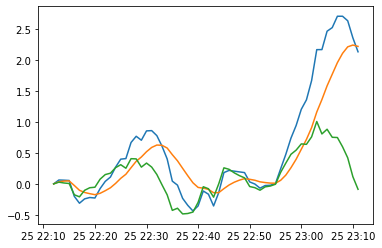

                         MACD  signal_line  histogram
time                                                 
2020-04-25 22:12:00  0.000000     0.000000   0.000000
2020-04-25 22:13:00  0.001122     0.000623   0.000499
2020-04-25 22:14:00  0.000809     0.000699   0.000110
2020-04-25 22:15:00  0.008590     0.003372   0.005218
2020-04-25 22:16:00 -0.004075     0.001157  -0.005232
2020-04-25 22:17:00 -0.007764    -0.001261  -0.006503
2020-04-25 22:18:00  0.000424    -0.000835   0.001258
2020-04-25 22:19:00  0.002102    -0.000129   0.002231
2020-04-25 22:20:00 -0.002721    -0.000728  -0.001993
2020-04-25 22:21:00  0.000078    -0.000547   0.000625
2020-04-25 22:22:00  0.006361     0.000964   0.005397
2020-04-25 22:23:00  0.010332     0.002976   0.007356
2020-04-25 22:24:00  0.020484     0.006681   0.013802
2020-04-25 22:25:00  0.033612     0.012315   0.021297
2020-04-25 22:26:00  0.038930     0.017832   0.021097
2020-04-25 22:27:00  0.052179     0.024901   0.027279
2020-04-25 22:28:00  0.05978

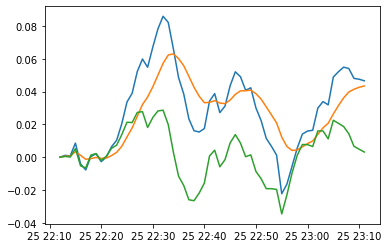

                             MACD   signal_line     histogram
time                                                         
2020-04-25 22:12:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-25 22:13:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-25 22:14:00  3.100994e-09  1.270899e-09  1.830095e-09
2020-04-25 22:15:00 -2.785534e-09 -1.032314e-10 -2.682303e-09
2020-04-25 22:16:00 -7.755169e-08 -2.314240e-08 -5.440929e-08
2020-04-25 22:17:00 -1.039343e-07 -4.504150e-08 -5.889283e-08
2020-04-25 22:18:00 -1.145334e-07 -6.262804e-08 -5.190534e-08
2020-04-25 22:19:00 -1.578467e-07 -8.551087e-08 -7.233580e-08
2020-04-25 22:20:00 -1.953613e-07 -1.108869e-07 -8.447446e-08
2020-04-25 22:21:00 -1.521688e-07 -1.201364e-07 -3.203238e-08
2020-04-25 22:22:00 -1.454609e-07 -1.256773e-07 -1.978365e-08
2020-04-25 22:23:00 -1.220848e-07 -1.249058e-07  2.820967e-09
2020-04-25 22:24:00 -1.200754e-07 -1.238835e-07  3.808113e-09
2020-04-25 22:25:00 -1.054205e-07 -1.200210e-07  1.460049e-08
2020-04-

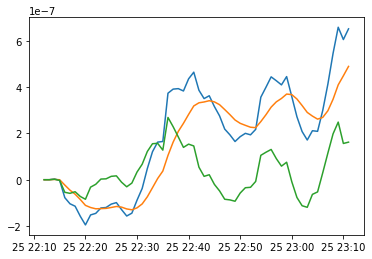

                             MACD  signal_line     histogram
time                                                        
2020-04-25 22:12:00  0.000000e+00     0.000000  0.000000e+00
2020-04-25 22:13:00  0.000000e+00     0.000000  0.000000e+00
2020-04-25 22:14:00 -3.876243e-06    -0.000002 -2.287619e-06
2020-04-25 22:15:00 -5.544237e-06    -0.000003 -2.615636e-06
2020-04-25 22:16:00 -1.359842e-06    -0.000002  1.102089e-06
2020-04-25 22:17:00  1.138347e-06    -0.000001  2.624402e-06
2020-04-25 22:18:00 -5.614658e-06    -0.000003 -3.083764e-06
2020-04-25 22:19:00 -2.918508e-06    -0.000003 -2.944625e-07
2020-04-25 22:20:00 -8.846023e-06    -0.000004 -4.784670e-06
2020-04-25 22:21:00 -1.292214e-05    -0.000006 -6.875459e-06
2020-04-25 22:22:00 -8.014709e-06    -0.000006 -1.537432e-06
2020-04-25 22:23:00 -4.417647e-06    -0.000006  1.617308e-06
2020-04-25 22:24:00 -8.018041e-06    -0.000006 -1.563396e-06
2020-04-25 22:25:00 -1.060885e-05    -0.000007 -3.285140e-06
2020-04-25 22:26:00 -1.2

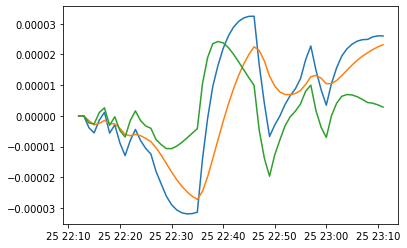

                         MACD  signal_line  histogram
time                                                 
2020-04-25 22:12:00  0.000000     0.000000   0.000000
2020-04-25 22:13:00  0.000067     0.000037   0.000030
2020-04-25 22:14:00  0.000070     0.000051   0.000019
2020-04-25 22:15:00  0.000157     0.000087   0.000070
2020-04-25 22:16:00 -0.000978    -0.000230  -0.000748
2020-04-25 22:17:00 -0.001744    -0.000640  -0.001104
2020-04-25 22:18:00 -0.002246    -0.001047  -0.001199
2020-04-25 22:19:00 -0.002542    -0.001406  -0.001136
2020-04-25 22:20:00 -0.002321    -0.001617  -0.000704
2020-04-25 22:21:00 -0.001414    -0.001572   0.000157
2020-04-25 22:22:00 -0.001171    -0.001484   0.000313
2020-04-25 22:23:00 -0.001306    -0.001446   0.000140
2020-04-25 22:24:00 -0.001124    -0.001378   0.000254
2020-04-25 22:25:00 -0.001164    -0.001333   0.000169
2020-04-25 22:26:00 -0.001001    -0.001264   0.000263
2020-04-25 22:27:00 -0.000301    -0.001066   0.000765
2020-04-25 22:28:00  0.00023

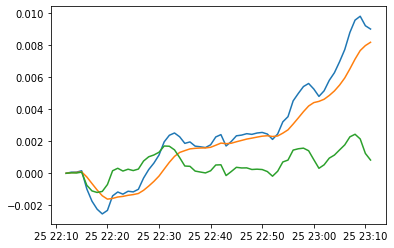

                             MACD   signal_line     histogram
time                                                         
2020-04-25 22:12:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-25 22:13:00 -4.487179e-10 -2.492877e-10 -1.994302e-10
2020-04-25 22:14:00  6.686419e-10  1.269129e-10  5.417290e-10
2020-04-25 22:15:00 -6.447786e-10 -1.345002e-10 -5.102784e-10
2020-04-25 22:16:00 -9.469745e-10 -3.761929e-10 -5.707815e-10
2020-04-25 22:17:00 -2.556235e-10 -3.435119e-10  8.788843e-11
2020-04-25 22:18:00  1.921497e-10 -2.079503e-10  4.000999e-10
2020-04-25 22:19:00  9.649039e-10  7.390866e-11  8.909952e-10
2020-04-25 22:20:00 -3.068953e-12  5.612645e-11 -5.919540e-11
2020-04-25 22:21:00  3.405086e-10  1.198446e-10  2.206640e-10
2020-04-25 22:22:00  2.182275e-09  5.710926e-10  1.611182e-09
2020-04-25 22:23:00  1.305638e-09  7.288421e-10  5.767959e-10
2020-04-25 22:24:00  2.332825e-09  1.068301e-09  1.264525e-09
2020-04-25 22:25:00  3.071390e-09  1.487349e-09  1.584042e-09
2020-04-

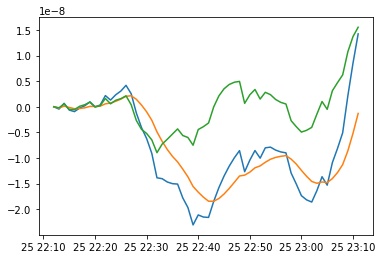

                             MACD   signal_line     histogram
time                                                         
2020-04-25 22:12:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-25 22:13:00 -6.282051e-09 -3.490028e-09 -2.792023e-09
2020-04-25 22:14:00 -8.004580e-09 -5.340255e-09 -2.664326e-09
2020-04-25 22:15:00 -8.591848e-09 -6.441743e-09 -2.150105e-09
2020-04-25 22:16:00 -1.050275e-07 -3.576876e-08 -6.925869e-08
2020-04-25 22:17:00 -1.755628e-07 -7.366071e-08 -1.019021e-07
2020-04-25 22:18:00 -2.177737e-07 -1.101319e-07 -1.076419e-07
2020-04-25 22:19:00 -1.117865e-07 -1.105295e-07 -1.256990e-09
2020-04-25 22:20:00 -3.768372e-08 -9.370177e-08  5.601805e-08
2020-04-25 22:21:00  1.543105e-08 -6.924968e-08  8.468073e-08
2020-04-25 22:22:00  5.359622e-08 -4.237170e-08  9.596792e-08
2020-04-25 22:23:00  7.974923e-08 -1.614525e-08  9.589447e-08
2020-04-25 22:24:00  9.808710e-08  8.030285e-09  9.005681e-08
2020-04-25 22:25:00  1.105393e-07  2.947525e-08  8.106405e-08
2020-04-

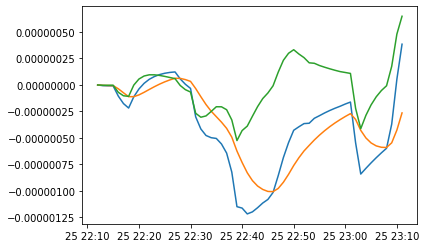

                         MACD   signal_line     histogram
time                                                     
2020-04-25 22:12:00  0.000000  0.000000e+00  0.000000e+00
2020-04-25 22:13:00  0.000000  0.000000e+00  0.000000e+00
2020-04-25 22:14:00 -0.000002 -9.023384e-07 -1.299367e-06
2020-04-25 22:15:00 -0.000003 -1.663445e-06 -1.485681e-06
2020-04-25 22:16:00 -0.000004 -2.238826e-06 -1.358818e-06
2020-04-25 22:17:00 -0.000004 -2.661893e-06 -1.137747e-06
2020-04-25 22:18:00 -0.000004 -2.966047e-06 -8.976871e-07
2020-04-25 22:19:00 -0.000004 -3.177177e-06 -6.674109e-07
2020-04-25 22:20:00 -0.000004 -3.314776e-06 -4.580560e-07
2020-04-25 22:21:00 -0.000004 -3.393704e-06 -2.733365e-07
2020-04-25 22:22:00 -0.000004 -3.425530e-06 -1.136360e-07
2020-04-25 22:23:00 -0.000003 -3.419460e-06  2.219449e-08
2020-04-25 22:24:00 -0.000005 -3.669870e-06 -9.328081e-07
2020-04-25 22:25:00 -0.000005 -4.041263e-06 -1.403903e-06
2020-04-25 22:26:00 -0.000006 -4.449588e-06 -1.561466e-06
2020-04-25 22:

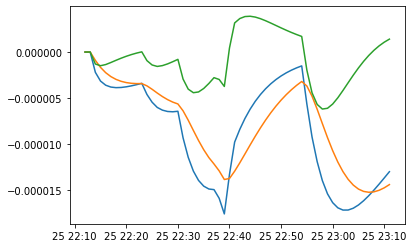

                             MACD  signal_line     histogram
time                                                        
2020-04-25 22:12:00  0.000000e+00     0.000000  0.000000e+00
2020-04-25 22:13:00  4.262821e-06     0.000002  1.894587e-06
2020-04-25 22:14:00  5.431679e-06     0.000004  1.807935e-06
2020-04-25 22:15:00  5.830183e-06     0.000004  1.459000e-06
2020-04-25 22:16:00 -1.596178e-05    -0.000002 -1.428437e-05
2020-04-25 22:17:00 -2.876168e-05    -0.000009 -1.974292e-05
2020-04-25 22:18:00 -3.647497e-05    -0.000016 -2.050778e-05
2020-04-25 22:19:00 -1.537820e-05    -0.000016  4.474449e-07
2020-04-25 22:20:00 -1.031236e-06    -0.000012  1.137683e-05
2020-04-25 22:21:00  8.646026e-06    -0.000008  1.633675e-05
2020-04-25 22:22:00  5.928112e-06    -0.000005  1.063911e-05
2020-04-25 22:23:00  8.249301e-06    -0.000002  1.017697e-05
2020-04-25 22:24:00  1.268573e-05     0.000001  1.152070e-05
2020-04-25 22:25:00  3.496724e-05     0.000008  2.673076e-05
2020-04-25 22:26:00  5.1

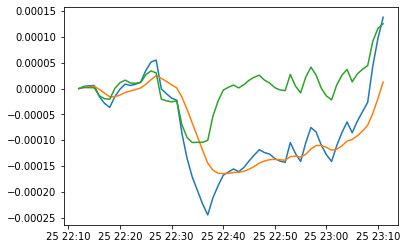

In [12]:
for symbol in symbols.keys():
    print(symbols[symbol].MACD)
    plt.plot(symbols[symbol].MACD)
    plt.show()

                         open      high       low     close   volume  \
time                                                                   
2020-04-25 22:50:00  0.025668  0.025669  0.025650  0.025650   20.882   
2020-04-25 22:51:00  0.025655  0.025656  0.025647  0.025648   29.926   
2020-04-25 22:52:00  0.025649  0.025654  0.025646  0.025646   10.919   
2020-04-25 22:53:00  0.025647  0.025650  0.025644  0.025644   26.220   
2020-04-25 22:54:00  0.025649  0.025649  0.025640  0.025640   25.255   
2020-04-25 22:55:00  0.025643  0.025643  0.025614  0.025614   90.361   
2020-04-25 22:56:00  0.025614  0.025645  0.025610  0.025645  127.591   
2020-04-25 22:57:00  0.025639  0.025656  0.025636  0.025647  155.088   
2020-04-25 22:58:00  0.025650  0.025650  0.025637  0.025642   15.009   
2020-04-25 22:59:00  0.025650  0.025657  0.025639  0.025657   21.073   
2020-04-25 23:00:00  0.025648  0.025656  0.025631  0.025634   15.281   
2020-04-25 23:01:00  0.025645  0.025657  0.025636  0.025644   26

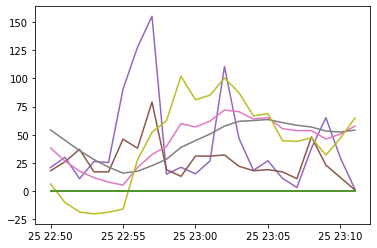

                        open     high      low    close     volume  \
time                                                                 
2020-04-25 22:50:00  7545.73  7546.70  7543.79  7543.89   8.638715   
2020-04-25 22:51:00  7543.79  7545.04  7540.96  7545.00  14.613200   
2020-04-25 22:52:00  7544.40  7547.54  7541.82  7544.47  20.875727   
2020-04-25 22:53:00  7544.39  7547.19  7542.21  7545.70   4.060666   
2020-04-25 22:54:00  7545.71  7546.46  7545.00  7545.32  10.184230   
2020-04-25 22:55:00  7545.61  7546.80  7542.57  7545.63  23.503996   
2020-04-25 22:56:00  7545.63  7550.00  7544.29  7548.43  20.213790   
2020-04-25 22:57:00  7548.59  7550.00  7547.70  7549.07   4.725156   
2020-04-25 22:58:00  7549.06  7550.84  7548.65  7550.16  11.610465   
2020-04-25 22:59:00  7550.60  7551.00  7548.76  7550.25  11.241254   
2020-04-25 23:00:00  7550.30  7551.77  7548.76  7551.70   8.836584   
2020-04-25 23:01:00  7551.70  7552.56  7550.00  7551.21   7.706171   
2020-04-25 23:02:00 

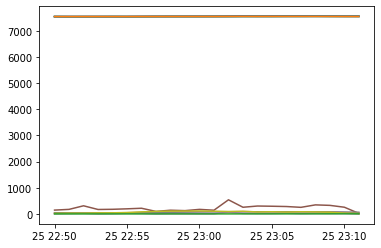

                       open    high     low   close     volume  \
time                                                             
2020-04-25 22:50:00  193.69  193.69  193.50  193.51  136.53082   
2020-04-25 22:51:00  193.52  193.56  193.42  193.54  371.16029   
2020-04-25 22:52:00  193.53  193.59  193.47  193.48   66.94286   
2020-04-25 22:53:00  193.48  193.59  193.43  193.53   59.39927   
2020-04-25 22:54:00  193.53  193.58  193.43  193.51  228.93331   
2020-04-25 22:55:00  193.50  193.50  193.25  193.26  307.44512   
2020-04-25 22:56:00  193.25  193.57  193.20  193.57  409.49070   
2020-04-25 22:57:00  193.54  193.70  193.52  193.65  316.48304   
2020-04-25 22:58:00  193.65  193.68  193.53  193.68  135.80353   
2020-04-25 22:59:00  193.65  193.71  193.64  193.68  240.40075   
2020-04-25 23:00:00  193.68  193.68  193.41  193.62  220.13746   
2020-04-25 23:01:00  193.65  193.74  193.53  193.61  315.54476   
2020-04-25 23:02:00  193.61  193.87  193.61  193.78  428.82099   
2020-04-25

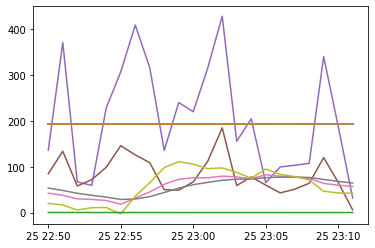

                         open      high       low     close   volume  \
time                                                                   
2020-04-25 22:50:00  0.002140  0.002141  0.002140  0.002141   177.12   
2020-04-25 22:51:00  0.002141  0.002141  0.002141  0.002141   110.66   
2020-04-25 22:52:00  0.002141  0.002142  0.002141  0.002141   202.97   
2020-04-25 22:53:00  0.002141  0.002142  0.002141  0.002141   447.09   
2020-04-25 22:54:00  0.002141  0.002143  0.002141  0.002143   155.22   
2020-04-25 22:55:00  0.002143  0.002143  0.002142  0.002142    94.74   
2020-04-25 22:56:00  0.002143  0.002143  0.002142  0.002142   173.00   
2020-04-25 22:57:00  0.002142  0.002143  0.002141  0.002142   301.99   
2020-04-25 22:58:00  0.002142  0.002142  0.002141  0.002142   346.20   
2020-04-25 22:59:00  0.002142  0.002143  0.002142  0.002142   129.68   
2020-04-25 23:00:00  0.002142  0.002142  0.002141  0.002141   198.96   
2020-04-25 23:01:00  0.002141  0.002142  0.002141  0.002141  252

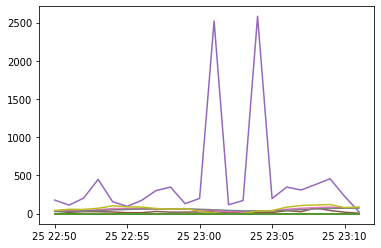

                         open      high       low     close  volume  \
time                                                                  
2020-04-25 22:50:00  0.083504  0.083504  0.083504  0.083504    0.50   
2020-04-25 22:51:00  0.083504  0.083504  0.083504  0.083504    0.00   
2020-04-25 22:52:00  0.083514  0.083523  0.083514  0.083523    1.58   
2020-04-25 22:53:00  0.083523  0.083523  0.083523  0.083523    0.00   
2020-04-25 22:54:00  0.083523  0.083523  0.083523  0.083523    0.51   
2020-04-25 22:55:00  0.083545  0.083545  0.083545  0.083545    0.26   
2020-04-25 22:56:00  0.083580  0.083593  0.083580  0.083593   29.92   
2020-04-25 22:57:00  0.083592  0.083592  0.083523  0.083591    9.92   
2020-04-25 22:58:00  0.083590  0.083590  0.083448  0.083448    5.68   
2020-04-25 22:59:00  0.083448  0.083448  0.083448  0.083448    1.00   
2020-04-25 23:00:00  0.083448  0.083448  0.083448  0.083448    0.00   
2020-04-25 23:01:00  0.083590  0.083590  0.083589  0.083589   13.73   
2020-0

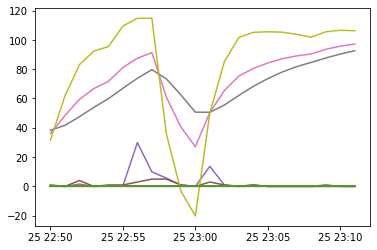

                        open     high      low    close   volume  \
time                                                               
2020-04-25 22:50:00  16.1583  16.1600  16.1550  16.1560   494.59   
2020-04-25 22:51:00  16.1581  16.1600  16.1517  16.1547   761.32   
2020-04-25 22:52:00  16.1598  16.1598  16.1517  16.1517   621.16   
2020-04-25 22:53:00  16.1507  16.1599  16.1500  16.1599  6230.87   
2020-04-25 22:54:00  16.1599  16.1686  16.1566  16.1666  4511.79   
2020-04-25 22:55:00  16.1666  16.1676  16.1573  16.1636  2864.35   
2020-04-25 22:56:00  16.1646  16.1739  16.1587  16.1736  8131.46   
2020-04-25 22:57:00  16.1707  16.1750  16.1698  16.1703   621.99   
2020-04-25 22:58:00  16.1727  16.1727  16.1700  16.1719   590.03   
2020-04-25 22:59:00  16.1719  16.1750  16.1697  16.1708   329.36   
2020-04-25 23:00:00  16.1708  16.1740  16.1604  16.1653   657.80   
2020-04-25 23:01:00  16.1673  16.1715  16.1634  16.1636  2990.58   
2020-04-25 23:02:00  16.1636  16.1751  16.1636  

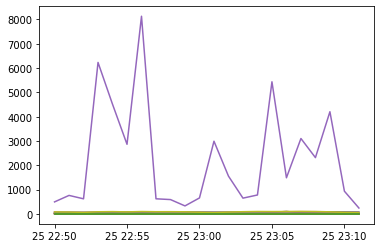

                        open     high      low    close   volume  \
time                                                               
2020-04-25 22:50:00  0.00002  0.00002  0.00002  0.00002  29585.0   
2020-04-25 22:51:00  0.00002  0.00002  0.00002  0.00002    388.0   
2020-04-25 22:52:00  0.00002  0.00002  0.00002  0.00002    551.0   
2020-04-25 22:53:00  0.00002  0.00002  0.00002  0.00002  38561.0   
2020-04-25 22:54:00  0.00002  0.00002  0.00002  0.00002   6973.0   
2020-04-25 22:55:00  0.00002  0.00002  0.00002  0.00002   2632.0   
2020-04-25 22:56:00  0.00002  0.00002  0.00002  0.00002  15426.0   
2020-04-25 22:57:00  0.00002  0.00002  0.00002  0.00002   4529.0   
2020-04-25 22:58:00  0.00002  0.00002  0.00002  0.00002    737.0   
2020-04-25 22:59:00  0.00002  0.00002  0.00002  0.00002  49763.0   
2020-04-25 23:00:00  0.00002  0.00002  0.00002  0.00002    505.0   
2020-04-25 23:01:00  0.00002  0.00002  0.00002  0.00002      5.0   
2020-04-25 23:02:00  0.00002  0.00002  0.00002  

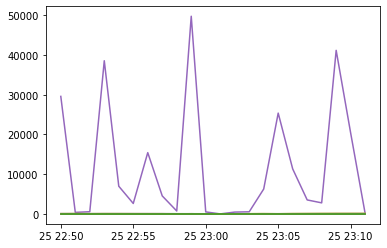

                         open      high       low     close  volume  \
time                                                                  
2020-04-25 22:50:00  0.000781  0.000781  0.000781  0.000781     0.0   
2020-04-25 22:51:00  0.000780  0.000780  0.000780  0.000780     5.0   
2020-04-25 22:52:00  0.000780  0.000780  0.000780  0.000780     0.0   
2020-04-25 22:53:00  0.000779  0.000779  0.000779  0.000779   299.0   
2020-04-25 22:54:00  0.000780  0.000780  0.000780  0.000780    14.0   
2020-04-25 22:55:00  0.000780  0.000780  0.000780  0.000780   462.0   
2020-04-25 22:56:00  0.000780  0.000780  0.000780  0.000780    13.0   
2020-04-25 22:57:00  0.000780  0.000780  0.000780  0.000780     0.0   
2020-04-25 22:58:00  0.000780  0.000780  0.000780  0.000780     0.0   
2020-04-25 22:59:00  0.000780  0.000780  0.000780  0.000780     0.0   
2020-04-25 23:00:00  0.000780  0.000780  0.000780  0.000780   218.0   
2020-04-25 23:01:00  0.000780  0.000780  0.000780  0.000780     0.0   
2020-0

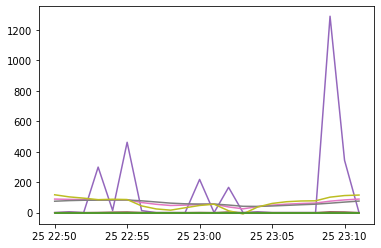

                         open      high       low     close  volume  \
time                                                                  
2020-04-25 22:50:00  0.009361  0.009361  0.009361  0.009361     0.0   
2020-04-25 22:51:00  0.009361  0.009361  0.009361  0.009361     0.0   
2020-04-25 22:52:00  0.009361  0.009361  0.009361  0.009361     0.0   
2020-04-25 22:53:00  0.009321  0.009361  0.009321  0.009361   679.0   
2020-04-25 22:54:00  0.009361  0.009361  0.009361  0.009361     0.0   
2020-04-25 22:55:00  0.009305  0.009305  0.009305  0.009305   200.0   
2020-04-25 22:56:00  0.009305  0.009305  0.009300  0.009300  1746.0   
2020-04-25 22:57:00  0.009300  0.009300  0.009300  0.009300  1451.0   
2020-04-25 22:58:00  0.009299  0.009299  0.009299  0.009299   100.0   
2020-04-25 22:59:00  0.009299  0.009300  0.009299  0.009299  2824.0   
2020-04-25 23:00:00  0.009299  0.009299  0.009299  0.009299     0.0   
2020-04-25 23:01:00  0.009299  0.009299  0.009299  0.009299     0.0   
2020-0

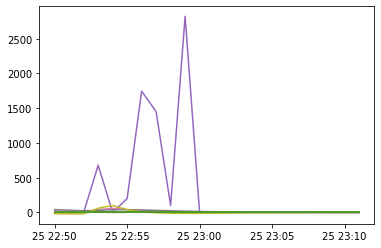

                        open     high      low    close   volume  \
time                                                               
2020-04-25 22:50:00  0.15051  0.15051  0.15050  0.15050   4539.0   
2020-04-25 22:51:00  0.15050  0.15050  0.15050  0.15050      0.0   
2020-04-25 22:52:00  0.15050  0.15050  0.15050  0.15050      0.0   
2020-04-25 22:53:00  0.15050  0.15100  0.15040  0.15100   1391.4   
2020-04-25 22:54:00  0.15098  0.15098  0.15032  0.15032   1466.1   
2020-04-25 22:55:00  0.15032  0.15032  0.15032  0.15032   1016.1   
2020-04-25 22:56:00  0.15089  0.15092  0.15089  0.15092    628.4   
2020-04-25 22:57:00  0.15092  0.15092  0.15092  0.15092    265.0   
2020-04-25 22:58:00  0.15050  0.15050  0.15050  0.15050   6378.1   
2020-04-25 22:59:00  0.15028  0.15028  0.15025  0.15025   2407.0   
2020-04-25 23:00:00  0.15025  0.15025  0.15025  0.15025    374.4   
2020-04-25 23:01:00  0.15025  0.15025  0.15025  0.15025      0.0   
2020-04-25 23:02:00  0.15026  0.15075  0.15026  

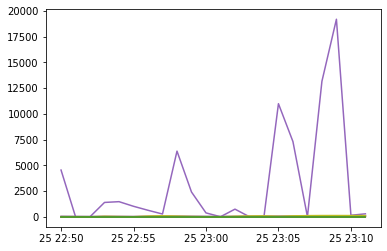

In [13]:
for symbol in symbols.keys():
    print(symbols[symbol].bollinger_bands)
    plt.plot(symbols[symbol].bollinger_bands)
    plt.show()

In [ ]:
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_strength_trigger.iloc[-1] and \
                        symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_strength_trigger.iloc[-1] and \
                        not symbols[symbol].trend_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_strength_trigger.iloc[-1] and \
                        symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_strength_trigger.iloc[-1] and \
                        not symbols[symbol].trend_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()

scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 0})
    scores.update({crypto_pair.quote_asset: 0})

while True:
    sleep(3)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    scores = {}
    for crypto_pair in symbols.values():
        scores.update({crypto_pair.base_asset: 0})
        scores.update({crypto_pair.quote_asset: 0})

    for asset in scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].trend_trigger.iloc[-1]:
                    scores.update({asset: scores[asset] + 1})
                else:
                    scores.update({asset: scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].trend_trigger.iloc[-1]:
                    scores.update({asset: scores[asset] - 1})
                else:
                    scores.update({asset: scores[asset] + 1})

    assets = scores.keys()
    best_assets = [asset for asset in scores.keys() if scores[asset] > 0]
    print('best_assets: ', best_assets)

    if not (symbols[traded_symbol].base_asset in best_assets or \
            symbols[traded_symbol].quote_asset in best_assets):

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in best_assets])]

        target_symbol = target_symbols[0]
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol

best_assets:  ['BTC', 'USDT']
best_assets:  ['USDT']
best_assets:  ['USDT']
best_assets:  ['ETH']
best_assets:  ['ETH', 'USDT']
best_assets:  ['ETH', 'USDT']


In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()